<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [80]:
macro javascript_str(s) display("text/javascript", s); end
javascript"$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')"

In [1]:
using MAT
using Plots
using MIRT
using LinearAlgebra
using FFTW
using LinearMaps
using OffsetArrays
using MATLAB
using IterativeSolvers
using LaTeXStrings
include("helper_functions.jl");

┌ Warning: /home/hakkelt/.julia/packages/Plots/WwFyB/src/Plots.jl/ is not an existing directory, Revise is not watching
└ @ Revise /home/hakkelt/.julia/packages/Revise/2NCCI/src/Revise.jl:488


# Setup
Setup MIRT and "reproduce-l-s-dynamic-mri" matlab projects

 - https://github.com/JeffFessler/mirt
 - https://github.com/JeffFessler/reproduce-l-s-dynamic-mri
   - And it is based on Ricardo Otazo's code: http://cai2r.net/resources/software/ls-reconstruction-matlab-code

In [3]:
mat"""
addpath('../mirt')
setup
addpath('../reproduce-l-s-dynamic-mri/data')
addpath('../reproduce-l-s-dynamic-mri/toolbox_pincat/')
addpath('../reproduce-l-s-dynamic-mri/operators/')
addpath('../reproduce-l-s-dynamic-mri/algorithms/')
"""

MATLAB.MEngineError: MATLAB.MEngineError("failed to open MATLAB engine session")

# Algorithms
All the algorithms below are described in [this paper](https://web.eecs.umich.edu/~fessler/papers/files/jour/19/web/lin-19-edp.pdf) by Claire Yilin Lin, and Jeffrey A. Fessler, and based on their [original implementation in Matlab](https://github.com/JeffFessler/reproduce-l-s-dynamic-mri).

## Augmented Lagrangian + Conjugate Gradient

**Problem formulation:** $argmin_{L,S}min_{U,W}\{\frac{1}{2}\lVert \textbf{E}(L+S) -d \lVert_2^2 + \lambda_L \lVert U \lVert_* + \lambda_S \lVert W \lVert_1\} \textrm{ subject to } \begin{cases} U = L \\ W = \textbf{T}S \end{cases}$

**Modified AL function:** $\frac{1}{2}\lVert \textbf{E}(L+S) -d \lVert_2^2 + \lambda_L \lVert U \lVert_* + \lambda_S \lVert W \lVert_1\ + \frac{\delta_1}{2} \lVert L - U + V_1 \lVert_2^2 + \frac{\delta_2}{2} \lVert \textbf{T}S - W + V_2 \lVert_2^2$

**Inputs:**

 - $d$: under-sampled multi-coil k-t data
 - $\textbf{E}$: Measurement operator
 - $\textbf{T}$: temporal Fourier tranform
 - $\lambda_L$: singular value threshold
 - $\lambda_S$: sparsity threshold
 - $iterL$: number of conjugate gradient iteration steps for $S$
 - $iterL$: number of conjugate gradient iteration steps for $L$
 - $\delta_1$, $\delta_2$: AL penalty parameters
 - $N$: number of iterations
 
**Initialization:** $L_0 = \textbf{E}^∗ d$, $S_0 = V_{1,0} = V_{2,0} = 0$

for $k = 1, 2, ... , N$ do
 - $P_k \leftarrow \textbf{SVT}_{\lambda_L / \delta_1} (L+V_2)$
 - $Q_k \leftarrow \textbf{T}^* \Lambda_{\lambda_S / \delta_2} (\textbf{T}S) + V_2 $
 - $L_k \leftarrow CG_{solver}\{\textrm{get } x \textrm{ s.t. } (\textbf{E}^*\textbf{E} + \delta_1\textbf{I})x = x_0 - \textbf{E}^*\textbf{E}S + \delta_1(P-V_1) \textrm{ starting from }L_{k-1}\}$,<br> where $x_0 = \textbf{E}^∗ d$ and $CG_{solver}$ is an iterative solver for conjugate gradient method
 - $S_k \leftarrow CG_{solver}\{\textrm{get } x \textrm{ s.t. } (\textbf{E}^*\textbf{E} + \delta_2\textbf{I})x = x_0 - \textbf{E}^*\textbf{E}L + \delta_2(Q-V_2) \textrm{ starting from }S_{k-1}\}$,<br> where $x_0 = \textbf{E}^∗ d$ and $CG_{solver}$ is an iterative solver for conjugate gradient method
 - $V_{1,k} \leftarrow V_{1,k-1} + L_k - P$
 - $V_{2,k} \leftarrow V_{2,k-1} + \textbf{T}S_k - Q$

end for

**output:** $L_N, S_N$ 

Respective Matlab code: https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/algorithms/AL_CG.m

In [194]:
function AL_CG(d::Array{Complex{Float64}},    # under-sampled k-t data
        E::LinearMap,                         # measurement operator
        T::LinearMap;                         # temporal Fourier tranform
        scale_L::Float64 = 1.,                # scaling factor for L
        scale_S::Float64 = 1.,                # scaling factor for S
        λ_L::Float64 = 0.01,                  # singular value threshold
        λ_S::Float64 = 0.05,                  # sparsity threshold
        δ₁::Float64 = 1. / 10,                # first AL penalty parameter
        δ₂::Float64 = 1. / 100,               # second AL penalty parameter
        iterL::Int64 = 3,                     # number of CG iteration steps for S
        iterS::Int64 = iterL,                 # number of CG iteration steps for L
        N::Int64 = 10)                        # number of iterations
    
    #Initialize
    @assert 3 ≤ ndims(d) ≤ 4
    if ndims(d) == 3
        nx,ny,nt = size(d)
    else
        nx,ny,nt,nc = size(d)
    end
    x₀ = reshape(E' * d[:], nx*ny, nt) # initial guess
    L, S = copy(x₀), zeros(Complex{Float64}, size(x₀))
    V₁, V₂ = zeros(size(L)), zeros(size(L))
    
    cost_vec = OffsetVector{Float64}(undef, 0:N)
    cost_vec[0] = cost(L, S, d, scale_L*λ_L, scale_S*λ_S)
    println("k = 0, rank = ", rank(L), ", cost = ", cost_vec[0])
    
    # Iteration
    for k in 1:N
        P = SVT(L + V₁, scale_L * λ_L / δ₁)
        Q = Λ(reshape(T * S[:], nx*ny, nt) + V₂, scale_S * λ_S / δ₂)
        L = cg!(L[:], E'*E + δ₁*I, x₀[:] - E'*E*S[:] + δ₁*(P-V₁)[:], tol=1e-5, maxiter=iterL)
        L = reshape(L, nx*ny, nt)
        S = cg!(S[:], E'*E + δ₂*I, x₀[:] - E'*E*L[:] + δ₂*T'*(Q-V₂)[:], tol=1e-5, maxiter=iterS)
        S = reshape(S, nx*ny, nt)
        V₁ += L - P
        V₂ += reshape(T*S[:], nx*ny, nt) - Q
        
        cost_vec[k] = cost(L, S, d, scale_L*λ_L, scale_S*λ_S)
        println("k = ", k, ", rank = ", rank(L), ", cost = ", cost_vec[k])
    end
    
    reshape(L, nx, ny, nt), reshape(S, nx, ny, nt), cost_vec
end

AL_CG (generic function with 2 methods)

## Improved Augmented Lagrangian

**Problem formulation:** $argmin_{L,S}min_{Z,X}\{\frac{1}{2}\lVert \boldsymbol{\Omega} Z -d \lVert_2^2 + \lambda_L \lVert L \lVert_* + \lambda_S \lVert \textbf{T}S \lVert_1\} \textrm{ subject to } \begin{cases} Z = \textbf{QC}X \\ X = L+S \end{cases}$

**Modified AL function:** $\frac{1}{2}\lVert \boldsymbol{\Omega} Z -d \lVert_2^2 + \lambda_L \lVert L \lVert_* + \lambda_S \lVert \textbf{T}S \lVert_1 + \frac{\delta_1}{2} \lVert Z - \textbf{QC} + V_1 \lVert_2^2 + \frac{\delta_2}{2} \lVert X - (L+S) + V_2 \lVert_2^2$

**Inputs:**
 - $d$: under-sampled multi-coil k-t data
 - $\boldsymbol{\Omega}$: under-sampling mask
 - $\textbf{Q}$: Fourier encoding operator
 - $\textbf{C}$: coil sensitivity maps
 - $\textbf{T}$: temporal Fourier tranform
 - $\lambda_L$: singular value threshold
 - $\lambda_S$: sparsity threshold
 - $\delta_1$, $\delta_2$: AL penalty parameters
 - $N$: number of iterations
 
**Initialization:** $X_0 = L_0 = C∗Q∗Ω∗d$, $S_0 = V_{1,0} = V_{2,0} = 0$

for $k = 1, 2, ... , N$ do
 - $Z_k \leftarrow argmin_Z \frac{1}{2} \lVert\boldsymbol{\Omega} Z-d\lVert_2^2 + \frac{\delta_1}{2}\lVert X - (L+S) + V_2\lVert_2^2 = (\boldsymbol{\Omega}^*\boldsymbol{\Omega} + \delta_1 \textbf{I})^{-1}(\boldsymbol{\Omega}^*d + \delta_1(\textbf{Q}\textbf{C}X - V_1))$
 - $X_k \leftarrow argmin_X \frac{\delta_1}{2} \lVert Z-\textbf{QC}X+V\_1 \lVert_2^2 + \frac{\delta_2}{2} \lVert X-(L+S) + V_2 \lVert_2^2$ $ = (\textbf{C}^*\textbf{C} + \frac{\delta_1}{\delta_2}\textbf{I})^{-1}(\textbf{C}^*\textbf{Q}^*(Z+V_1)+\frac{\delta_1}{\delta_2}(L+S+V_2)) = \frac{\delta_1}{\delta_1+\delta_2}(\textbf{C}^*\textbf{Q}^*(Z+V_1) + \frac{\delta_2}{\delta_1}(L+S-V_2))$
 - $L_k \leftarrow argmin_L (\lambda_L \lVert L \lVert_* + \frac{\delta_2}{2} \lVert X - (L + S) + V_2 \lVert_2^2) = \textbf{SVT}_{\lambda_L / \delta_2} (X-S+V_2)$
 - $S_k \leftarrow argmin_S (\lambda_S \lVert \textbf{T} S \lVert_1 + \frac{\delta_2}{2} \lVert X - (L + S) + V_2 \lVert_2^2)$ $ = \textbf{T}^* (argmin_S (\lambda_S \lVert \tilde{S} \lVert_1 + \frac{\delta_2}{2} \lVert \textbf{T}(X - (L + S) + V_2) - \tilde{S} \lVert_2^2)$ $ = \textbf{T}^* \Lambda_{\lambda_S / \delta_2} (\textbf{T}(X - L + V_2)) $ where $\tilde{S} = \textbf{T}S$
 - $V_{1,k} \leftarrow V_{1,k-1} + (Z_k − \textbf{QC}X_k)$
 - $V_{2,k} \leftarrow V_{2,k-1} + X_k − (L_k + S_k)$

end for

**output:** $L_N, S_N$ 

Respective Matlab code: https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/algorithms/AL_2.m

In [187]:
function AL_2(d::Array{Complex{Float64}},     # under-sampled k-t data
        Ω::LinearMap,                         # under-sampling mask
        Q::LinearMap,                         # Fourier encoding operator
        C::LinearMap,                         # coil sensitivity maps
        T::LinearMap;                         # temporal Fourier tranform
        scale_L::Float64 = 1.,                # scaling factor for L
        scale_S::Float64 = 1.,                # scaling factor for S
        λ_L::Float64 = 0.01,                  # singular value threshold
        λ_S::Float64 = 0.05,                  # sparsity threshold
        δ₁::Float64 = 1. / 10,                # first AL penalty parameter
        δ₂::Float64 = 1. / 100,               # second AL penalty parameter
        N::Int64 = 10)                        # number of iterations
    
    #Initialize
    @assert 3 ≤ ndims(d) ≤ 4
    if ndims(d) == 3
        nx,ny,nt = size(d)
    else
        nx,ny,nt,nc = size(d)
    end
    E = Ω * Q * C
    x₀ = reshape(E' * d[:], nx*ny, nt) # initial guess
    L = copy(x₀)
    S = zeros(Complex{Float64}, size(L))
    X = L + S
    V₁ = zeros(size(d))
    V₂ = zeros(size(L))
    Z_scaler = repeat(1 ./ (samp .+ δ₁),1,1,1,nc) # equivalent to (Ω'*Ω + δ₁*I)'
    
    cost_vec = OffsetVector{Float64}(undef, 0:N)
    cost_vec[0] = cost(L, S, d, scale_L*λ_L, scale_S*λ_S)
    println("k = 0, rank = ", rank(L), ", cost = ", cost_vec[0])
    
    # Iteration
    for k in 1:N
        Z = Z_scaler .* reshape(Ω'*d[:] + δ₁*(Q*C*X[:] - V₁[:]), nx, ny, nt, nc)
        X = δ₁/(δ₁+δ₂)*reshape(C'*Q'*(Z + V₁)[:],nx*ny,nt) + δ₂/(δ₁+δ₂)*(L + S - V₂)
        L = SVT(X - S + V₂, scale_L * λ_L / δ₂)
        S = reshape(T' * Λ(reshape(T * (X - L + V₂)[:], nx*ny, nt), scale_S * λ_S / δ₂)[:], nx*ny, nt)
        V₁ += Z - reshape(Q*C*X[:], nx,ny,nt,nc)
        V₂ += X - L - S
        
        cost_vec[k] = cost(L, S, d, scale_L*λ_L, scale_S*λ_S)
        println("k = ", k, ", rank = ", rank(L), ", cost = ", cost_vec[k])
    end
    
    reshape(L, nx, ny, nt), reshape(S, nx, ny, nt), cost_vec
end

AL_2 (generic function with 2 methods)

## Proximal Gradient Methods

**Inputs:**

 - $d$: under-sampled k-t data
 - $\textbf{E}$: data acquisition operator
 - $\textbf{T}$: temporal Fourier transform
 - $\lambda_L$: singular value threshold
 - $\lambda_S$: sparsity threshold
 - $N$: number of iterations
 - $momentum$: update rule (ISTA/FISTA/POGM)
 
**Initialization:** $M_0 = L_0 = \tilde{L}_0 = \bar{L}_0 = E∗d, S_0 = 0, \theta_0 = \zeta_0 = 1, t = 0.5 \textrm{ (for FISTA and POGM) or } 0.99 \textrm{ (for ISTA)}$

for $k = 1, 2, ... , N$ do

 - $\tilde{L}_k \leftarrow M_{k-1} - S_{k-1}$
 - $\tilde{S}_k \leftarrow M_{k-1} - L_{k-1}$
 - $\theta_k \leftarrow \begin{cases} \frac{1+\sqrt{1 + 4\theta_{k-1}^2}}{2} \\ \frac{1+\sqrt{1 + 8\theta_{k-1}^2}}{2} \end{cases}$
 - $\bar{X}_k \leftarrow \begin{cases} \tilde{X}_k : momentum = ISTA \\ \tilde{X}_k + \frac{\theta_{k-1}-1}{\theta_k}(\tilde{X}_k - \tilde{X}_{k-1}) + \frac{\theta_{k-1}}{\theta_k}(\tilde{X}_k - X_{k-1}) : momentum = FISTA \\ \tilde{X}_k + \frac{\theta_{k-1}-1}{\theta_k}(\tilde{X}_k - \tilde{X}_{k-1}) + \frac{\theta_{k-1}}{\theta_k}(\tilde{X}_k - X_{k-1}) + \frac{\theta_{k-1}-1}{\zeta_{k-1} \theta_k}(\bar{X}_{k-1} - X_{k-1}) : momentum = POGM \end{cases}$
 - $\zeta_k \leftarrow t(1+\frac{\theta_{k-1}-1}{\theta_k} + \frac{\theta_{k-1}}{\theta_k})$
 - $L_k \leftarrow \textbf{SVT}_{\lambda_L}(\bar{L}_k)$
 - $S_k \leftarrow \textbf{T}^*(\Lambda_{\lambda_S}[\textbf{T}(\bar{S}_k)])$
 - $M_k \leftarrow L_k + S_k - t\textbf{E}^* (\textbf{E}(L_k +S_k)-d)$

end for

**output:** $X_N$

This funciton creates the following construct: $X = \begin{bmatrix}L \\ S\end{bmatrix}$ in such a way that modifying $L$ or $S$ also takes effect in $X$, and vice versa.

In [231]:
function createXLS(row_dim,nt)
    X = zeros(Complex{Float64}, row_dim, 2*nt)
    L = view(X, :, 1:nt)
    S = view(X, :, nt+1:2*nt)
    return X,L,S
end
function allocate(row_dim,nt)
    createXLS(row_dim,nt)..., createXLS(row_dim,nt)...
end

@swap (macro with 1 method)

Respective Matlab code: https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/algorithms/PGM.m

In [232]:
function PGM(d::Array{Complex{Float64}},    # under-sampled k-t data
        E::LinearMap,                       # measurement operator
        T::LinearMap;                       # sparsifying operator
        scale_L::Float64 = 1.,              # scaling factor for L
        scale_S::Float64 = 1.,              # scaling factor for S
        tscale::Float64 = 1.,               # scaling factor for t
        λ_L::Float64 = 0.01,                # singular value threshold
        λ_S::Float64 = 0.05,                # sparsity threshold
        nc::Int64 = size(d,4),              # number of coils
        N::Int64 = 10,                      # number of iterations
        restart::Bool = true,               # reset θₖ if cost increased or not
        momentum::Symbol = :pogm)           # update rule (:pogm, :ista, :fista)
    
    #Initialize
    @assert 3 ≤ ndims(d) ≤ 4
    if ndims(d) == 3
        nx,ny,nt = size(d)
    else
        nx,ny,nt,nc = size(d)
    end
    x₀ = E' * d[:] # initial guess
    row_dim = prod(size(x₀)) ÷ nt
    
    Xₖ₋₁,Lₖ₋₁,Sₖ₋₁,Xₖ,Lₖ,Sₖ = allocate(row_dim,nc)
    X̃ₖ₋₁,L̃ₖ₋₁,S̃ₖ₋₁,X̃ₖ,L̃ₖ,S̃ₖ = allocate(row_dim,nc)
    X̄ₖ₋₁,L̄ₖ₋₁,S̄ₖ₋₁,X̄ₖ,L̄ₖ,S̄ₖ = allocate(row_dim,nc)
    Lₖ₋₁ .= reshape(x₀, row_dim, nt)
    X̄ₖ₋₁ .= X̃ₖ₋₁ .= Xₖ₋₁
    
    t = (in(momentum, (:fista, :pogm)) ? .5 : .99) * tscale
    Mₖ₋₁ = reshape(x₀[:] - t*E' * (E * x₀[:] - d)[:], row_dim, nt)
    θₖ₋₁ = ζₖ₋₁ = 1.
    
    cost_vec = OffsetVector{Float64}(undef, 0:N)
    cost_vec[0] = cost(Lₖ₋₁, Sₖ₋₁, d, scale_L*λ_L, scale_S*λ_S)
    println("k = 0, rank = ", rank(Lₖ₋₁), ", cost = ", cost_vec[0])
    
    # Iteration
    for k in 1:N
        L̃ₖ .= Mₖ₋₁ .- Sₖ₋₁
        S̃ₖ .= Mₖ₋₁ .- Lₖ₋₁
        θₖ  = (1 + √(1 + (k < N ? 4 : 8)*θₖ₋₁^2))/2
        if momentum == :pogm
            @. X̄ₖ = X̃ₖ + (θₖ₋₁-1)/θₖ*(X̃ₖ - X̃ₖ₋₁) +
                (θₖ₋₁)/θₖ*(X̃ₖ - Xₖ₋₁) + (θₖ₋₁-1)/(ζₖ₋₁*θₖ)*t*(X̄ₖ₋₁ - Xₖ₋₁)
        elseif momentum == :fista
            @. X̄ₖ = X̃ₖ + (θₖ₋₁-1)/θₖ*(X̃ₖ - X̃ₖ₋₁)
        else
            @. X̄ₖ = X̃ₖ
        end
        ζₖ  = t*(1 + (θₖ₋₁-1)/θₖ + (θₖ₋₁)/θₖ)
        Lₖ .= SVT(L̄ₖ, scale_L*λ_L)
        Sₖ .= reshape(T' * Λ(T * S̄ₖ[:], scale_S*λ_S)[:], row_dim, nt)
        Mₖ = Lₖ + Sₖ - reshape(t * E' * (E * (Lₖ + Sₖ)[:] - d)[:], row_dim, nt)
        
        cost_vec[k] = cost(Lₖ, Sₖ, d, scale_L*λ_L, scale_S*λ_S)
        println("k = ", k, ", rank = ", rank(Lₖ), ", cost = ", cost_vec[k])
        
        if restart && cost_vec[k] > cost_vec[k - 1]
            θₖ₋₁ = θₖ = 1.
            println("   Restarted!")
        end
        
        # Move (k) -> (k-1), and avoid allocation for new (k)
        #      => switch (k) and (k-1) matrices
        @swap(Xₖ₋₁,Xₖ); @swap(X̃ₖ₋₁,X̃ₖ); @swap(X̄ₖ₋₁,X̄ₖ)
        @swap(Lₖ₋₁,Lₖ); @swap(L̃ₖ₋₁,L̃ₖ); @swap(L̄ₖ₋₁,L̄ₖ)
        @swap(Sₖ₋₁,Sₖ); @swap(S̃ₖ₋₁,S̃ₖ); @swap(S̄ₖ₋₁,S̄ₖ)
        @swap(Mₖ₋₁,Mₖ)
        θₖ₋₁, ζₖ₋₁ = θₖ, ζₖ
    end
    
    reshape(Lₖ, nx, ny, nt), reshape(Sₖ, nx, ny, nt), cost_vec
end

PGM (generic function with 2 methods)

In [233]:
@time L, S, j_cost_ista = PGM(d, E, T, nc=nc, scale_L = 0.0274/1.099, scale_S = 1/1.099,
    tscale = 1.3002, λ_L = 0.025, λ_S = 0.5*maximum(abs, recon_nufft), momentum=:ista);

InexactError: InexactError: Float64(-9.622160603332203e-7 + 1.1805555853431514e-6im)

The general POGM function above can also calculate the FISTA iterations, but this version follows the description of FISTA algorithm in the referenced paper (and thus also the Matlab implementation).

In [219]:
function FISTA(d::Array{Complex{Float64}}, # under-sampled k-t data
        E::LinearMap,                      # measurement operator
        T::LinearMap;                      # sparsifying operator
        scale_L::Float64 = 1.,             # scaling factor for L
        scale_S::Float64 = 1.,             # scaling factor for S
        tscale::Float64 = 1.,              # scaling factor for t
        λ_L::Float64 = 0.01,               # singular value threshold
        λ_S::Float64 = 0.05,               # sparsity threshold
        nc::Int64 = size(d,4),             # number of coils
        N::Int64 = 10,                     # number of iterations
        restart::Bool = true,              # reset θₖ if cost increased or not
        momentum::Symbol = :pogm)          # update rule (:pogm, :ista, :fista)
    
    #Initialize
    Xₖ₋₁,Lₖ₋₁,Sₖ₋₁,Xₖ,Lₖ,Sₖ = createXLS()..., createXLS()...
    X̃ₖ₋₁,L̃ₖ₋₁,S̃ₖ₋₁,X̃ₖ,L̃ₖ,S̃ₖ = createXLS()..., createXLS()...
    Lₖ₋₁ .= reshape(E' * d[:], nx*ny, nt)
    Sₖ₋₁ .= zeros(Complex{Float64}, nx*ny, nt)
    L̃ₖ₋₁ .= Lₖ₋₁
    S̃ₖ₋₁ .= zeros(Complex{Float64}, nx*ny, nt)
    t = 0.5*tscale
    θₖ₋₁ = 1
    diff = (E*(Lₖ₋₁ + Sₖ₋₁)[:])[:] - d[:]
    M = (Lₖ₋₁ + Sₖ₋₁) - t*reshape(E'*diff, nx*ny,nt)
    
    cost_vec = OffsetVector{Float64}(undef, 0:N)
    cost_vec[0] = cost(Lₖ₋₁, Sₖ₋₁, d, scale_L*λ_L, scale_S*λ_S)
    println("k = 0, rank = ", rank(Lₖ₋₁), ", cost = ", cost_vec[0])
    
    # Iteration
    for k in 1:N
        Lₖ .= SVT(M - S̃ₖ₋₁, scale_L*λ_L*t)
        Sₖ .= reshape(T'*Λ(T*(M - L̃ₖ₋₁)[:], scale_S*λ_S*t)[:], nx*ny,nt)
        cost_vec[k] = cost(Lₖ, Sₖ, d, scale_L*λ_L, scale_S*λ_S)
        println("k = ", k, ", rank = ", rank(Lₖ), ", cost = ", cost_vec[k])
        θₖ = (1+sqrt(1+4*θₖ₋₁^2))/2
        X̃ₖ .= Xₖ + (θₖ₋₁-1)/θₖ * (Xₖ - Xₖ₋₁)
        diff = E * reshape(L̃ₖ + S̃ₖ,nx,ny,nt)[:] - d
        M = L̃ₖ + S̃ₖ - t * reshape(E'*diff[:], nx*ny,nt)
        θₖ₋₁ = θₖ
        @swap(Xₖ₋₁,Xₖ); @swap(X̃ₖ₋₁,X̃ₖ)
        @swap(Lₖ₋₁,Lₖ); @swap(L̃ₖ₋₁,L̃ₖ)
        @swap(Sₖ₋₁,Sₖ); @swap(S̃ₖ₋₁,S̃ₖ)
    end
    
    reshape(Lₖ, nx, ny, nt), reshape(Sₖ, nx, ny, nt), cost_vec
end

FISTA (generic function with 2 methods)

# Operators
## All-in-one measurement operator

In [8]:
function getE(nx::Int64, ny::Int64, nt::Int64, nc::Int64,
              samp::Array{Float64,3},smap::Array{Complex{Float64},3})
    mask = repeat(samp,1,1,1,nc) .== 1
    reshaped_smap = reshape(smap,nx,ny,1,nc)
    LinearMap{Complex{Float64}}(
        x -> begin # Don't ask me, why did Mr Otazo use ifft instead of fft...
                xcoils = reshape(x,nx,ny,nt,1) .* reshaped_smap
                X=fftshift(ifft(ifftshift(xcoils,1),1),1)*√(nx)
                X=fftshift(ifft(ifftshift(X,2),2),2)*√(ny)
                X.*mask
            end,
        y -> begin # But he used it consistently, so it doesn't make a big difference
                x=fftshift(fft(ifftshift(reshape(y,nx,ny,nt,nc).*mask,1),1),1)/√(nx)
                x=fftshift(fft(ifftshift(x,2),2),2)/√(ny)
                sum(conj.(reshaped_smap).*x,dims=4)
            end,
        nx*ny*nt*nc, nx*ny*nt)
end

getE (generic function with 1 method)

## Components of measurement operator separately

In [9]:
function getΩQC(nx::Int64, ny::Int64, nt::Int64, nc::Int64,
              samp::Array{Float64,3},smap::Array{Complex{Float64},3})
    mask = repeat(samp,1,1,1,nc) .== 1
    reshaped_smap = reshape(smap,nx,ny,1,nc)
    C = LinearMap{Complex{Float64}}(
        x -> reshape(x,nx,ny,nt,1) .* reshaped_smap,
        y -> sum(conj.(reshaped_smap) .* reshape(y, nx, ny, nt, nc), dims=4),
        nx*ny*nt*nc, nx*ny*nt)
    Q = LinearMap{Complex{Float64}}(
        x -> begin
            X=fftshift(ifft(ifftshift(reshape(x,nx,ny,nt,nc),1),1),1)*√(nx)
            fftshift(ifft(ifftshift(X,2),2),2)*√(ny)
        end,
        X -> begin
            x=fftshift(fft(ifftshift(reshape(X,nx,ny,nt,nc),1),1),1)/√(nx)
            fftshift(fft(ifftshift(x,2),2),2)/√(ny)
        end,
        nx*ny*nt*nc, nx*ny*nt*nc)
    Ω = LinearMap{Complex{Float64}}(
        x -> reshape(x,nx,ny,nt,nc).*mask,
        y -> y,
        nx*ny*nt*nc, nx*ny*nt*nc)
    return Ω, Q, C
end

getΩQC (generic function with 1 method)

## Measurement operator with non-uniform FFT
Respective Matlab code: https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/operators/getEnufft.m

`E_basis` function is found in `helper_functions.jl`

In [176]:
function getEnufft(sense_maps::Array{Complex{Float64},3};
    ksp::Array, om::Array, wi::Array = [])
    
    nx,ny,nc = size(sense_maps)
    M,_,nt = size(ksp)
    n_shift = (nx,ny) .÷ 2
    
    #basistransform = E_basis("dirac", M=M, nt=nt, fov=(22,22), N=(nx,ny), ksp=ksp)
    st = [nufft_init(om[:,:,tt], (nx,ny), n_shift=collect(n_shift)) for tt = 1:nt]
    
    E = LinearMap{Complex{Float64}}(
        x -> begin
            S = zeros(M,nt,nc)
            x = reshape(x, nx, ny, nt, 1)
            for tt=1:nt
                tmp = x[:,:,tt,:] .* sense_maps
                S[:,tt,:] = reshape(st[tt].nufft(tmp) / √(nx*ny), M, 1, nc)
            end,
            #S .* basistransform
            S
        end,
        S -> begin
            x = zeros(Complex{Float64}, nx,ny,nt)
            S = reshape(S, M,nt,nc)
            #S = S .* conj.(basistransform)
            wi ≠ [] && (S = S .* wi) # cl: from otazo
            for tt = 1:nt # cl: '/sqrt(prod(a.imSize))' from otazo
                tmp = reshape(st[tt].adjoint(S[:,tt,:]) / √(nx*ny), nx, ny, nc)
                x[:,:,tt] = sum(tmp .* conj.(sense_maps), dims=3)
            end
            x
            end,
        M*nt*nc, nx*ny*nt
    )
end

getEnufft (generic function with 1 method)

## Sparsifying transform
A Fourier transform along the time dimension

In [10]:
function getT(nx::Int64,ny::Int64,nt::Int64)
    LinearMap{Complex{Float32}}(
        x -> fftshift(fft(reshape(x, nx, ny, nt),3),3)/√(nt),
        y -> ifft(ifftshift(reshape(y, nx, ny, nt),3),3)*√(nt),
        nx*ny*nt, nx*ny*nt)
end

getT (generic function with 1 method)

# Helper functions
#### Thresholding

In [11]:
pos(x) = x < 0 ? zero(x) : x
Λ(v,p) = @. sign(v) * pos(abs(v) - p)

SVT(A,p) = begin
    F = svd(A)
    F.U*Diagonal(Λ(F.S,p))*F.Vt
end

SVT (generic function with 1 method)

#### Norms

In [12]:
normₙ(A) = sum(svdvals(A))
norm₁(A) = norm(A, 1)
norm₂(A) = norm(A, 2)

norm₂ (generic function with 1 method)

#### Cost function

In [13]:
cost(L,S,d,λ_L,λ_S) = 0.5*norm₂(E*(L + S)[:] - d)^2 + λ_L*normₙ(L) + λ_S*norm₁(T * S[:])

cost (generic function with 1 method)

# PINCAT phantom example
https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/examples/example_PINCAT_phantom.m

## Preparation

### Read data
#### Matlab code

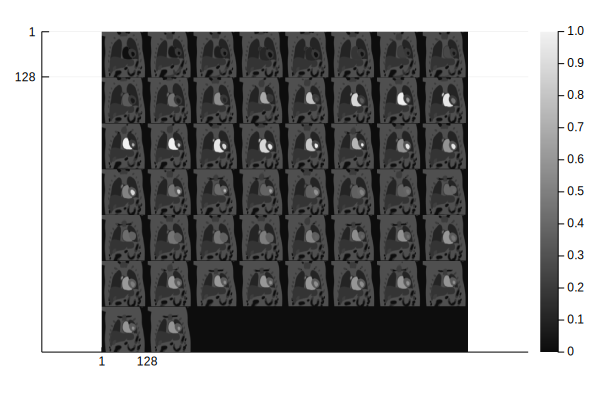

In [14]:
mat"""
% L+S reconstruction of undersampled multicoil PINCAT phantom
% Claire Lin, 06/05/2018
clear all;close all;
load('data/aperiodic_pincat.mat')
load('data/Xinf.mat')
% EDIT! I added the following line to rotate the image 
new = permute(new, [2, 1, 3]);
tmp = max(new(:));
Xtrue = div0(new,tmp);
[nx,ny,nt] = size(Xtrue);
"""
@mget Xtrue
jim(Xtrue)

#### Julia equivalent

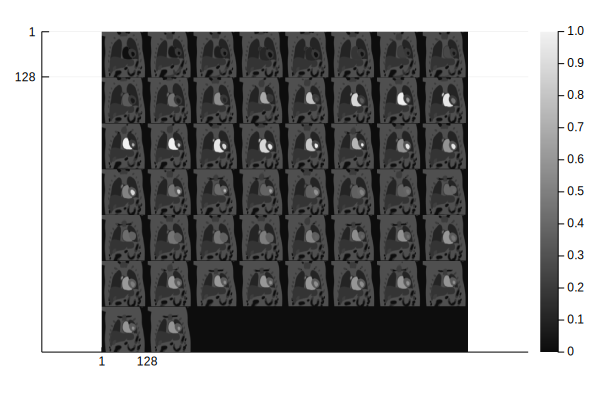

In [15]:
data = matread("../reproduce-l-s-dynamic-mri/data/aperiodic_pincat.mat")["new"]
Xtrue = permutedims(data, [2, 1, 3]) ./ maximum(data)
nx,ny,nt = size(Xtrue);
jim(Xtrue)

### Simulate coil maps
#### Matlab code
Code for `ir_mri_sensemap_sim`: https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/toolbox_pincat/ir_mri_sensemap_sim.m

┌ Warning: magnitude at jim.jl 129 jim(): 
└ @ MIRT /home/hakkelt/.julia/packages/MIRT/013iB/src/plot/jim.jl:130


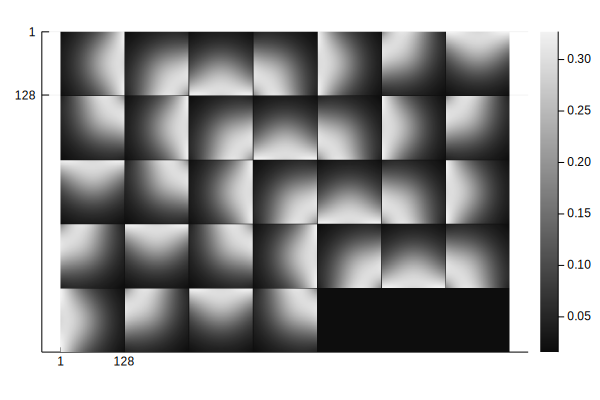

In [16]:
mat"""
% 4 rings of 8 coils
nc = 8;
nring = 4;
% WARNING! In the line below, I made a modification: I changed "'ny', 1, 'nz', ny"
% to "'ny', ny, 'nz', 1" because I think it was a mistake and also it matches
% the implementation found in MIRT.jl 
b1 = ir_mri_sensemap_sim('chat', 0, 'nx', nx, 'ny', ny, 'nz', 1,'dx', 1.5, 'dz', 1.5, ...
    'rcoil', 120, 'nring', nring, 'ncoil', nc*nring, 'coil_distance', 1.2);
tmp = sqrt(sum(abs((b1)).^2,3));
b1c = div0(b1,tmp);
"""
@mget b1c
jim(b1c)

#### Julia equivalent
`ir_mri_sensemap_sim` is part of MIRT.jl
 - https://github.com/JeffFessler/MIRT.jl/blob/master/src/mri/sensemap-sim.jl

┌ Warning: magnitude at jim.jl 129 jim(): 
└ @ MIRT /home/hakkelt/.julia/packages/MIRT/013iB/src/plot/jim.jl:130


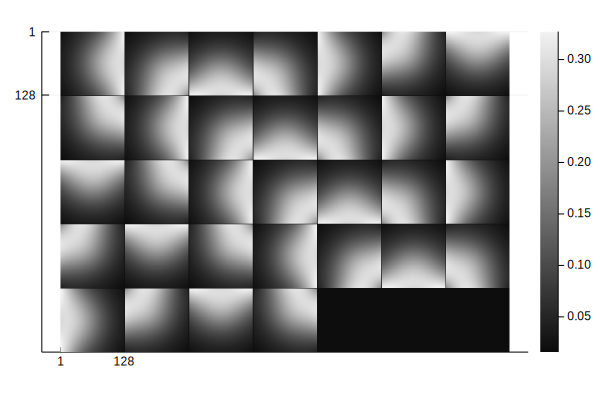

In [17]:
nc = 8;
nring = 4;
b1,_ = ir_mri_sensemap_sim(dims=(nx,ny), dx=1.5, dz=1.5,
    ncoil=nc*nring, nring=nring, rcoil=120, coil_distance=1.2, chat=false)
b1c = b1 ./ repeat(sqrt.(sum(abs2.(b1), dims=3)),outer=[1,1,nc*nring])
jim(b1c)

### Coil compression to 8 coils
MRI coil compression via PCA<br>
Given multiple MRI surface coil images (b1c), use SVD/PCA to find a smaller number of virtual coil images.
#### Matlab code

┌ Warning: magnitude at jim.jl 129 jim(): 
└ @ MIRT /home/hakkelt/.julia/packages/MIRT/013iB/src/plot/jim.jl:130


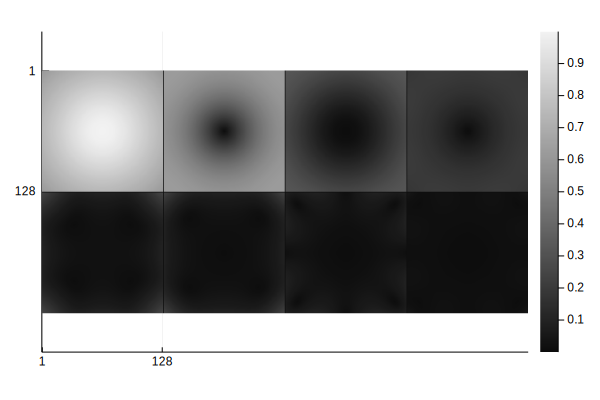

In [18]:
mat"""
[smap0, ~] = ir_mri_coil_compress(b1c, 'ncoil', nc);
tmp = sqrt(sum(abs((smap0)).^2,3));
smap = div0(smap0,tmp);
"""
@mget smap
jim(smap)

#### Julia equivalent
Function `ir_mri_coil_compress` is found in `helper_functions.jl`

┌ Warning: magnitude at jim.jl 129 jim(): 
└ @ MIRT /home/hakkelt/.julia/packages/MIRT/013iB/src/plot/jim.jl:130


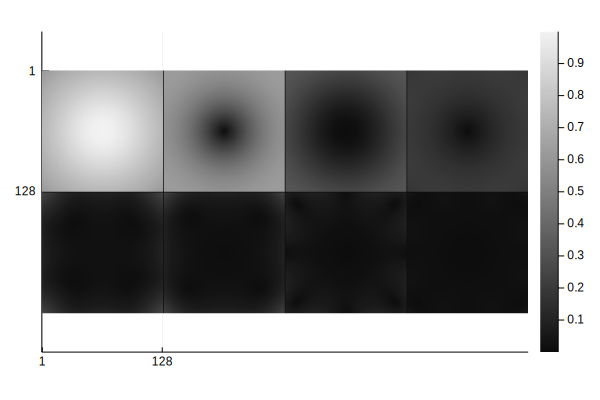

In [19]:
smap0,_,_ = ir_mri_coil_compress(b1c, ncoil=nc);
smap = smap0 ./ sqrt.(sum(abs2.(smap0), dims=3))
jim(smap)

### Sampling mask
#### Matlab code
Code for `strucrand` can be found here: https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/toolbox_pincat/strucrand.m

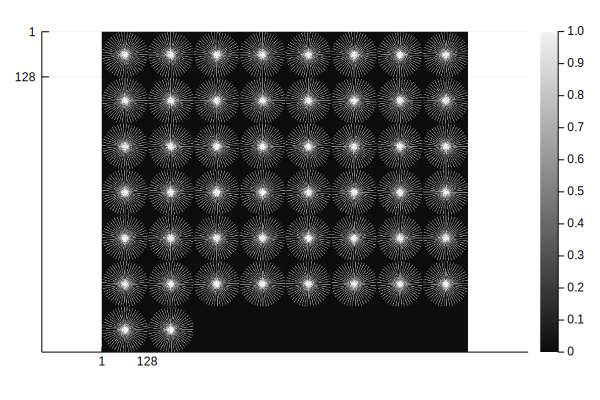

In [20]:
mat"""
line = 24;
samp = strucrand(nx,ny,nt,line);
"""
@mget samp
jim(samp)

#### Julia equivalent
Function `strucrand` is found in `helper_functions.jl`

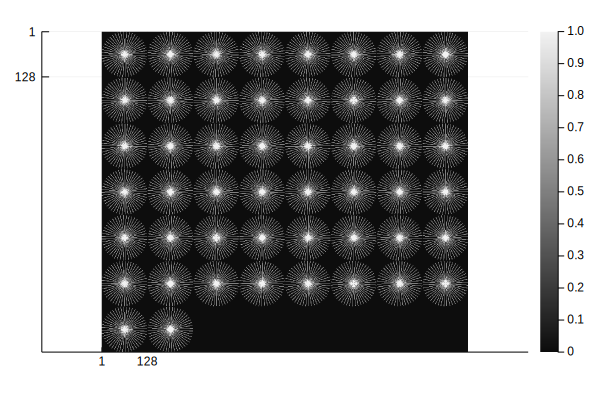

In [21]:
line = 24
samp = strucrand(nx,ny,nt,line)
pre_mask = fftshift(fftshift(repeat(samp,1,1,1,nc),1),2)
mask = pre_mask .== 1
jim(samp)

### Measurement operator and measured data
#### Matlab code
Code for `getE`: https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/operators/getE.m

In [22]:
mat"""
E=getE(smap,nt,'samp',samp);
"""

#### Julia equivalent

In [23]:
@mget samp # samp has some randomness, so I will use the sampling map generated by Matlab
E = getE(nx,ny,nt,nc,samp,convert.(Complex{Float64}, smap))

LinearMaps.FunctionMap{Complex{Float64}}(#10, #11, 6553600, 819200; ismutating=false, issymmetric=false, ishermitian=false, isposdef=false)

Let's check out if the Matlab and the Julia operators are equivalent!

In [24]:
eval_string("d = E*Xtrue; Xrecovered = E'*d;")
@mget d Xrecovered
ytrue = reshape(E * Xtrue[:],nx,ny,nt,nc)
Xrecov = reshape(E'*ytrue[:],nx,ny,nt)
maximum(abs, d - ytrue), maximum(abs, Xrecovered - Xrecov)

(6.443632096650787e-6, 1.2256674878984992e-6)

The most reasonable explanation for the difference above is that Matlab implementation works with complex numbers based on `Float32`, but this Julia code uses `Float64`. (`Float32` guaranteed to have only 6 significant digits...)

In [25]:
println("Matlab: type of d: ", typeof(d))
println("Julia: type of ytrue: ", typeof(ytrue))

Matlab: type of d: Array{Complex{Float32},4}
Julia: type of ytrue: Array{Complex{Float64},4}


Just an interesting fact: `fft` function is based on FFTW (http://www.fftw.org/) in both Matlab and Julia; however, there is a minor, but significant (100x larger than machine epsilon) difference between the two...

In [26]:
A = rand(1000)
matlab = mxcall(:fft, 1, A)
julia = fft(A, 1)
maximum(abs, matlab - julia), eps(Float64), typeof(matlab), typeof(julia)

(2.847716647714797e-14, 2.220446049250313e-16, Array{Complex{Float64},1}, Array{Complex{Float64},1})

Get components of measurement operator separately:

In [27]:
@mget samp # samp has some randomness, so I will use the sampling map generated by Matlab
Ω, Q, C = getΩQC(nx, ny, nt, nc, convert.(Float64, samp), convert.(Complex{Float64}, smap))

(LinearMaps.FunctionMap{Complex{Float64}}(#18, #19, 6553600, 6553600; ismutating=false, issymmetric=false, ishermitian=false, isposdef=false), LinearMaps.FunctionMap{Complex{Float64}}(#16, #17, 6553600, 6553600; ismutating=false, issymmetric=false, ishermitian=false, isposdef=false), LinearMaps.FunctionMap{Complex{Float64}}(#14, #15, 6553600, 819200; ismutating=false, issymmetric=false, ishermitian=false, isposdef=false))

A quick check if they produces the same result together as the "all-in-one" measurement operator

In [28]:
maximum(abs,C'*Q'*Ω'*Ω*Q*C*Xtrue[:] - E'*E*Xtrue[:])

0.0

### Add noise and prepare for regularization scaling
Add complex noise such that the $SNR = 46dB$
#### Matlab code

In [29]:
mat"""
rng(0)
dn = randn(size(d)) + 1i * randn(size(d));
param.snr_db = 46;
param.scale_noise = norm(d(:)) / norm(dn(:)) / 10.^(param.snr_db / 20);
param.d = d + param.scale_noise * dn;
printm('data rmse = %g, snr = %g', rms(param.d(:)-d(:)), ...
    20*log10(norm(d(:)) / norm(param.d(:)-d(:))))
opt.d = param.d;

% prepare for regularization scaling
L = E'*param.d; 
res = E*L-param.d;
[~,St,~]=svd(reshape(L,[nx*ny,nt])-reshape(E'*res,[nx*ny,nt]),0);
"""

>> >> >> >> >> >> >> >> : data rmse = 0.000425539, snr = 46


#### Julia equivalent

In [30]:
noise = randn(size(ytrue)) + randn(size(ytrue))im # complex noise!
snr_dB = 46;
scale_noise = norm(ytrue) / norm(noise) / 10^(snr_dB / 20);
y = ytrue + scale_noise * noise
rms(x) = norm(x-ytrue) / sqrt(length(x-ytrue))
snr(x) = 20 * log10(norm(ytrue) / norm(x-ytrue))
@show rms(y)
@show snr(y);

rms(y) = 0.00042553927387646773
snr(y) = 46.00000000000001


### Sparsifying transform
A Fourier transform along the time dimension
#### Matlab code
Code for `getT`: https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/operators/getT.m

In [31]:
mat"""
T = getT(nx,ny,nt);
sparsified = T*Xtrue;
inv_sparsified = T'*T*Xtrue;
"""
@mget sparsified inv_sparsified;

#### Julia equivalent

In [32]:
T = getT(nx,ny,nt)

LinearMaps.FunctionMap{Complex{Float32}}(#26, #27, 819200, 819200; ismutating=false, issymmetric=false, ishermitian=false, isposdef=false)

Let's check out if the Matlab and the Julia operators are equivalent!

In [33]:
maximum(abs, T*Xtrue[:] - sparsified), maximum(abs, T'*(T*Xtrue[:])[:] - inv_sparsified[:])

(1.3322676295501878e-15, 7.783183730659471e-16)

## Test algorithms

### Get scaling value required by all algorithms

In [34]:
x₀ = reshape(E' * y[:], nx*ny, nt)
St = svdvals(x₀ - reshape(E' * (E * x₀[:] - y)[:], nx*ny, nt));

### Run AL-CG
#### Matlab code

In [35]:
mat"""
opt.smap = smap;
opt.T=getT(nx,ny,nt);
opt.nite = 10;
opt.samp = samp;
[opt.F,opt.C] = getFS(opt.smap,nt,'samp',opt.samp);
opt.E=getE(smap,nt,'samp',opt.samp);
opt.scaleL = St(1);
opt.scaleS = 1/1.887; %1 / b1 constant squared in middle of image
opt.muL=0.01;
opt.muS=0.05*opt.scaleS;
opt.Xinf = Xinf.pincat;
d1 = 1/2; d2 = 1/2;
"""

In [36]:
@time eval_string("[L_cg,S_cg,x_cg,cost_cg,time_cg,rankL_cg] = AL_CG(opt,'d1',d1,'d2',d2);") 

>>  ite: 0, xdiff: 146.6454163, cost: 949.4185793, rank of L: 50
 ********** AL-CG: L+S reconstruction **********
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 3.1e-05.
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 0.00035.
 ite: 1 , rank of L: 49, xdiff: 148.6108703, cost: 864.7294923
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 1.8e-05.
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 0.0003.
 ite: 2 , rank of L: 25, xdiff: 148.1047213, cos

#### Julia equivalent

In [37]:
@time L, S, j_cost_cg = AL_CG(y, E, T,
    scale_L = maximum(St), scale_S = 1/1.887, δ₁ = 1/2, δ₂ = 1/2);

k = 0, rank = 50, cost = 949.4177729093954
k = 1, rank = 50, cost = 865.4087547033881
k = 2, rank = 50, cost = 816.8192032458259
k = 3, rank = 50, cost = 792.5940505700039
k = 4, rank = 50, cost = 767.0715865761856
k = 5, rank = 50, cost = 754.5232642893623
k = 6, rank = 50, cost = 748.7821323780796
k = 7, rank = 50, cost = 744.6426688205883
k = 8, rank = 50, cost = 741.5281151476911
k = 9, rank = 50, cost = 737.9459691609973
k = 10, rank = 50, cost = 733.62000003586
133.980757 seconds (9.56 M allocations: 227.605 GiB, 5.24% gc time)


#### Comparism

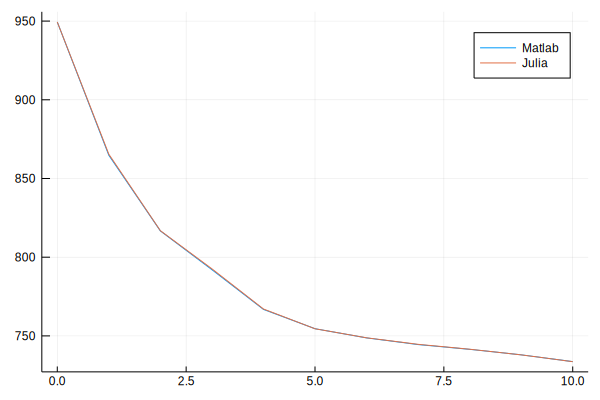

In [38]:
@mget cost_cg
plot(0:10, cost_cg[:], label="Matlab")
plot!(0:10, collect(j_cost_cg), label="Julia")

### Run AL-2
#### Matlab code

In [39]:
mat"""
d1 = 1/3; d2 = 1/10;
"""
@time eval_string("[L_al,S_al,xdiff_al,cost_al,time_al,rankL_al] = AL_2(opt,'d1',d1,'d2',d2);")

>>  ite: 0, xdiff: 146.6454163, cost: 949.4185793, rank of L: 50
 ********** AL-2: L+S reconstruction **********
 ite: 1 , rank of L: 3, xdiff: 136.4413603, cost: 1416.6546633
 ite: 2 , rank of L: 3, xdiff: 141.0376433, cost: 962.0929573
 ite: 3 , rank of L: 4, xdiff: 145.2325443, cost: 817.0456543
 ite: 4 , rank of L: 6, xdiff: 147.4587103, cost: 747.7221683
 ite: 5 , rank of L: 7, xdiff: 148.4452363, cost: 724.5869143
 ite: 6 , rank of L: 7, xdiff: 148.8675543, cost: 717.6232303
 ite: 7 , rank of L: 8, xdiff: 149.0431983, cost: 712.9367073
 ite: 8 , rank of L: 8, xdiff: 149.1040343, cost: 709.9216313
 ite: 9 , rank of L: 8, xdiff: 149.0889893, cost: 708.4229743
 ite: 10 , rank of L: 8, xdiff: 149.0245213, cost: 707.3890383
 24.066191 seconds (23 allocations: 1.250 KiB)


#### Julia equivalent

In [40]:
@time L, S, j_cost_al = AL_2(y, Ω, Q, C, T,
    scale_L = maximum(St), scale_S = 1/1.887, δ₁ = 1/3, δ₂ = 1/10.);

k = 0, rank = 50, cost = 949.5083801088081
k = 1, rank = 3, cost = 1416.6599004414197
k = 2, rank = 3, cost = 962.0927739204649
k = 3, rank = 4, cost = 817.031024573117
k = 4, rank = 6, cost = 747.7246798150787
k = 5, rank = 7, cost = 724.6170465862805
k = 6, rank = 7, cost = 717.6809190127343
k = 7, rank = 8, cost = 712.9769570453726
k = 8, rank = 8, cost = 709.9734086969148
k = 9, rank = 8, cost = 708.4736749784901
k = 10, rank = 8, cost = 707.4376949036091
 36.998860 seconds (2.38 M allocations: 60.117 GiB, 10.76% gc time)


#### Comparism

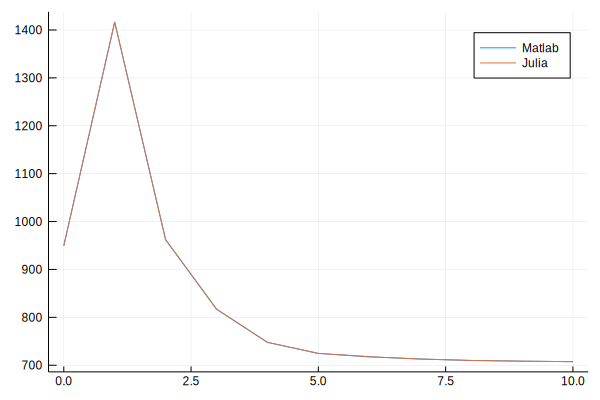

In [41]:
@mget cost_al
plot(0:10, cost_al[:], label="Matlab")
plot!(0:10, collect(j_cost_al), label="Julia")

### Run ISTA
#### Matlab code

In [42]:
mat"""
param.E = getE(smap,nt,'samp',samp);
param.T = getT(nx,ny,nt);
param.nite = 10;
param.scaleL = St(1);
param.scaleS = 1/1.887; %1 / b1 constant squared in middle of image
param.lambda_L=0.01;
param.lambda_S=0.05*param.scaleS;
param.Xinf = reshape(Xinf.pincat,nx*ny,nt);
"""
@time eval_string("[L_ista,S_ista,xdiff_ista,cost_ista,time_ista,rankL_ista] = PGM(param);")

>>  ite: 0, xdiff: 146.6454163, cost: 949.4185793, rank of L: 50
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 21, xdiff: 146.8076173, cost: 786.1989753
 ite: 2, rank of L: 15, xdiff: 147.1760413, cost: 753.8728033
 ite: 3, rank of L: 13, xdiff: 147.6357423, cost: 739.9907843
 ite: 4, rank of L: 12, xdiff: 147.9189153, cost: 733.3142093
 ite: 5, rank of L: 12, xdiff: 147.9933323, cost: 729.6292113
 ite: 6, rank of L: 12, xdiff: 148.1933593, cost: 726.9968873
 ite: 7, rank of L: 11, xdiff: 148.1407473, cost: 724.8903203
 ite: 8, rank of L: 11, xdiff: 148.3262633, cost: 723.1130983
 ite: 9, rank of L: 11, xdiff: 148.2495883, cost: 721.5773933
 ite: 10, rank of L: 11, xdiff: 148.4051823, cost: 720.2354133
  2.542726 seconds (23 allocations: 1.250 KiB)


#### Julia equivalent

In [43]:
@time L, S, j_cost_ista = PGM(y, E, T, 
    scale_L = maximum(St), scale_S = 1/1.887, momentum=:ista);

k = 0, rank = 50, cost = 949.4177729093954
k = 1, rank = 22, cost = 785.9469369026383
k = 2, rank = 16, cost = 753.590233558574
k = 3, rank = 14, cost = 739.809258739114
k = 4, rank = 12, cost = 733.1582607465355
k = 5, rank = 12, cost = 729.5149075392164
k = 6, rank = 12, cost = 726.8551462211431
k = 7, rank = 12, cost = 724.7706446559926
k = 8, rank = 12, cost = 722.9722820305627
k = 9, rank = 11, cost = 721.4563615686704
k = 10, rank = 11, cost = 720.1011044496415
 28.041385 seconds (9.14 M allocations: 40.969 GiB, 2.00% gc time)


#### Comparism

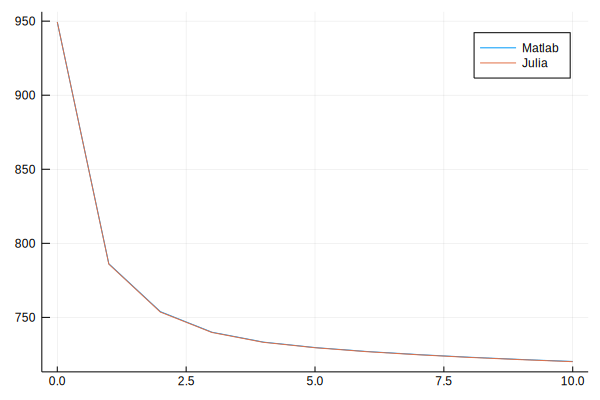

In [44]:
@mget cost_ista
plot(0:10, cost_ista[:], label="Matlab")
plot!(0:10, collect(j_cost_ista), label="Julia")

### Run FISTA
#### Matlab code

In [45]:
@time eval_string("[L_fista,S_fista,xdiff_fista,cost_fista,time_fista,rankL_fista] = PGM(param,'fistaL',1,'fistaS',1);")

>>  ite: 0, xdiff: 146.6454163, cost: 949.4185793, rank of L: 50
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 33, xdiff: 146.5078123, cost: 831.2001953
 ite: 2, rank of L: 23, xdiff: 146.6440123, cost: 788.1049193
 ite: 3, rank of L: 18, xdiff: 146.9966283, cost: 762.9733893
 ite: 4, rank of L: 15, xdiff: 147.3972323, cost: 747.1497193
 ite: 5, rank of L: 13, xdiff: 147.7686313, cost: 737.0789793
 ite: 6, rank of L: 12, xdiff: 148.0625463, cost: 731.5498663
 ite: 7, rank of L: 12, xdiff: 148.2351993, cost: 727.9229133
 ite: 8, rank of L: 11, xdiff: 148.3392033, cost: 725.0133673
 ite: 9, rank of L: 11, xdiff: 148.4178013, cost: 722.4732063
 ite: 10, rank of L: 10, xdiff: 148.4870453, cost: 720.2481083
  3.767511 seconds (23 allocations: 1.250 KiB)


#### Julia equivalent

In [46]:
@time L, S, j_cost_fista = PGM(y, E, T,
    scale_L = maximum(St), scale_S = 1/1.887, momentum=:fista);

k = 0, rank = 50, cost = 949.4177729093954
k = 1, rank = 22, cost = 803.5225956884277
k = 2, rank = 14, cost = 776.0375549520072
k = 3, rank = 10, cost = 761.7568401203517
k = 4, rank = 9, cost = 752.4697639024516
k = 5, rank = 9, cost = 747.0154489109229
k = 6, rank = 9, cost = 743.1049472997416
k = 7, rank = 9, cost = 740.0538587809689
k = 8, rank = 8, cost = 737.4163441747012
k = 9, rank = 8, cost = 735.2235369288617
k = 10, rank = 8, cost = 734.0056111462225
 23.473566 seconds (499.00 k allocations: 40.553 GiB, 4.22% gc time)


In [47]:
@time L, S, j_cost_fista2 = FISTA(y, E, T,
    scale_L = maximum(St), scale_S = 1/1.887);

k = 0, rank = 50, cost = 949.4177729093954
k = 1, rank = 39, cost = 831.1997173291056
k = 2, rank = 25, cost = 788.1037670655128
k = 3, rank = 19, cost = 762.9721121432102
k = 4, rank = 16, cost = 747.1488492472515
k = 5, rank = 14, cost = 737.0777126069511
k = 6, rank = 12, cost = 731.5483697087874
k = 7, rank = 12, cost = 727.920953878156
k = 8, rank = 12, cost = 725.0114218936083
k = 9, rank = 12, cost = 722.4715630496398
k = 10, rank = 11, cost = 720.2463494195651
 24.390133 seconds (4.36 M allocations: 41.680 GiB, 2.27% gc time)


#### Comparism

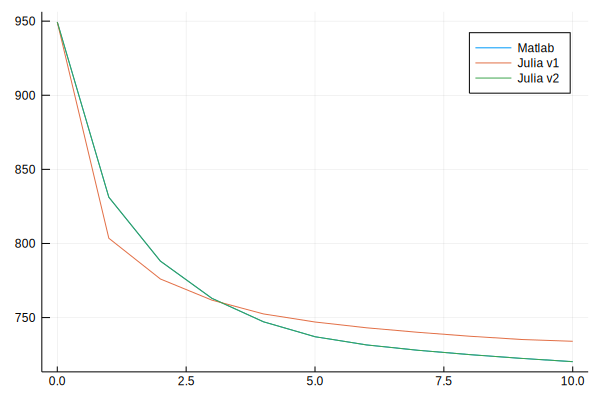

In [48]:
@mget cost_fista
plot(0:10, cost_fista[:], label="Matlab")
plot!(0:10, collect(j_cost_fista), label="Julia v1")
plot!(0:10, collect(j_cost_fista2), label="Julia v2")

The difference here is due to difference locations where cost function evaluated inside an iteration, and also the different ordering of steps. "Julia v1" is the FISTA variant of the general `PGM` method, and thus executes the steps of FISTA in the same order as ISTA and POGM, and evaluates the cost function in the end of the iteration. On the other hand, "Julia v2" follows the description of FISTA algorithm in the referenced paper (and thus also the Matlab implementation), therefore it reproduces successfully the results of the paper.

### Run POGM
#### Matlab code

In [49]:
@time eval_string("[L_pogm,S_pogm,xdiff_pogm,cost_pogm,time_pogm,rankL_pogm] = PGM(param,'pogmS',1,'pogmL',1);")

>>  ite: 0, xdiff: 146.6454163, cost: 949.4185793, rank of L: 50
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 23, xdiff: 146.6580663, cost: 796.5960693
 ite: 2, rank of L: 15, xdiff: 147.1858983, cost: 754.4551393
 ite: 3, rank of L: 12, xdiff: 147.8896943, cost: 736.4732063
 ite: 4, rank of L: 12, xdiff: 148.2933813, cost: 729.3807983
 ite: 5, rank of L: 11, xdiff: 148.3951113, cost: 724.8982543
 ite: 6, rank of L: 10, xdiff: 148.4918523, cost: 721.2432253
 ite: 7, rank of L: 9, xdiff: 148.5566863, cost: 718.2484743
 ite: 8, rank of L: 9, xdiff: 148.5669563, cost: 715.6806643
 ite: 9, rank of L: 9, xdiff: 148.5583193, cost: 713.5289313
 ite: 10, rank of L: 9, xdiff: 148.5541083, cost: 712.1857913
  2.831044 seconds (23 allocations: 1.250 KiB)


#### Julia equivalent

In [50]:
@time L, S, j_cost_pogm = PGM(y, E, T,
    scale_L = maximum(St), scale_S = 1/1.887, momentum=:pogm);

k = 0, rank = 50, cost = 949.4177729093954
k = 1, rank = 22, cost = 790.3396381262985
k = 2, rank = 16, cost = 751.9039109848221
k = 3, rank = 13, cost = 736.256896577541
k = 4, rank = 12, cost = 730.7337979747349
k = 5, rank = 12, cost = 727.0006473131097
k = 6, rank = 12, cost = 724.0801242134685
k = 7, rank = 12, cost = 721.401621799379
k = 8, rank = 12, cost = 719.2842278993851
k = 9, rank = 11, cost = 717.3630882994689
k = 10, rank = 11, cost = 714.1844914848194
 19.609060 seconds (988.76 k allocations: 40.573 GiB, 1.74% gc time)


#### Comparism

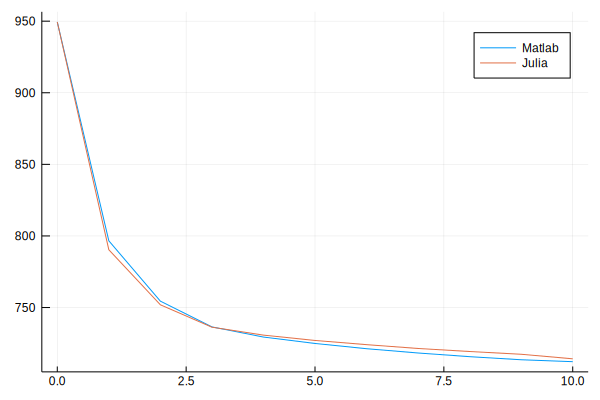

In [51]:
@mget cost_pogm
plot(0:10, cost_pogm[:], label="Matlab")
plot!(0:10, collect(j_cost_pogm), label="Julia")

## Show POGM result

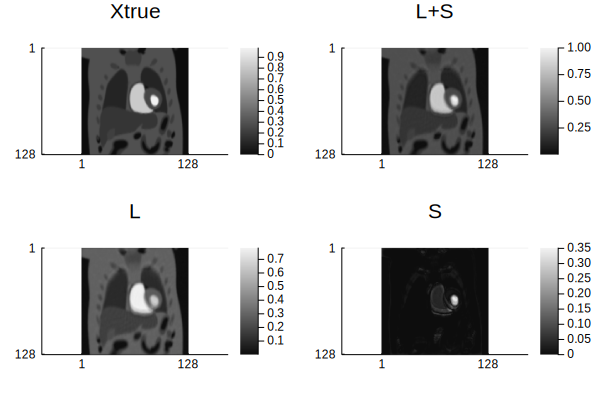

In [52]:
tpick = 21
ps = []
push!(ps, jim(Xtrue[:,:,tpick], "Xtrue", abswarn=false))
push!(ps, jim((L+S)[:,:,tpick], "L+S", abswarn=false))
push!(ps, jim(L[:,:,tpick], "L", abswarn=false))
push!(ps, jim(S[:,:,tpick], "S", abswarn=false))
plot(ps..., layout=(2,2))

┌ Warning: magnitude at none 0 #jim(): 
└ @ MIRT /home/hakkelt/.julia/packages/MIRT/013iB/src/plot/jim.jl:130


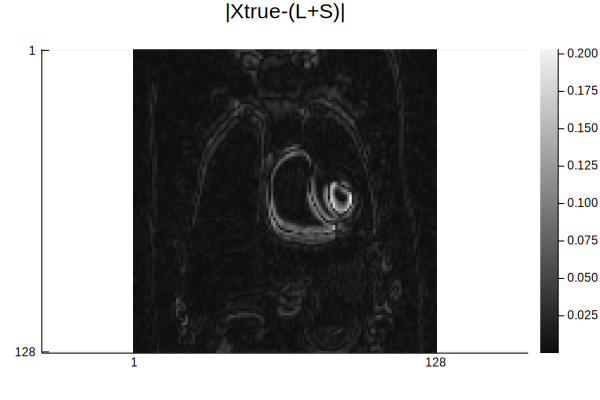

In [53]:
jim((L+S)[:,:,tpick] - Xtrue[:,:,tpick], "|Xtrue-(L+S)|")

# Multicoil cardiac cine MRI
https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/examples/example_cardiac_cine.m

## Preparation

### Read data
#### Matlab code

In [106]:
mat"""
% L+S reconstruction of undersampled multicoil cardiac cine MRI
% Claire Lin, 05/20/2018
clear all;close all;
load('../reproduce-l-s-dynamic-mri/data/cardiac_cine_R6.mat')
load ('../reproduce-l-s-dynamic-mri/data/Xinf.mat')
%% normalize smap
[nx,ny,nt,nc]=size(kdata);
tmp = sqrt(sum(abs((b1)).^2,3));
b1c = div0(b1,tmp);
"""

#### Julia equivalent

┌ Warning: magnitude at jim.jl 129 jim(): 
└ @ MIRT /home/hakkelt/.julia/packages/MIRT/013iB/src/plot/jim.jl:130


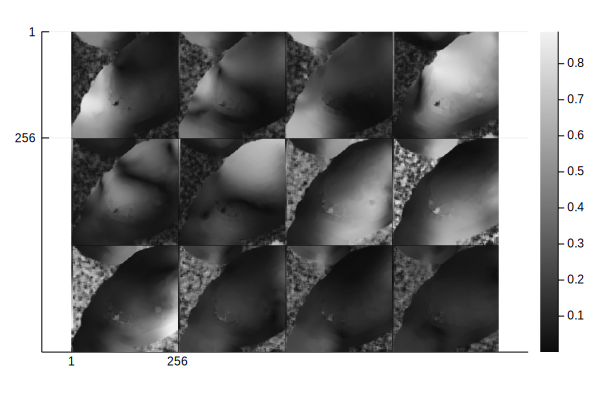

In [107]:
data = matread("../reproduce-l-s-dynamic-mri/data/cardiac_cine_R6.mat")
kdata, b1 = data["kdata"], data["b1"]
nx,ny,nt,nc = size(kdata)
b1c = b1 ./ sqrt.(sum(abs2, b1, dims=3))
jim(b1c)

Sampling pattern:

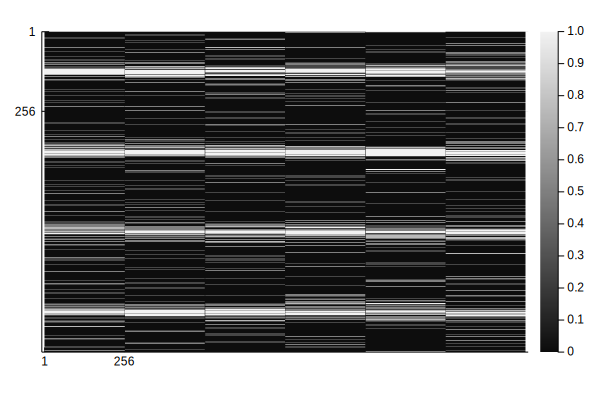

In [108]:
samp = kdata[:,:,:,1] .!= 0
jim(samp)

In [109]:
E = getE(nx, ny, nt, nc, Float64.(samp), b1c)
Ω, Q, C = getΩQC(nx, ny, nt, nc, Float64.(samp), b1c)
T = getT(nx,ny,nt)

LinearMaps.FunctionMap{Complex{Float32}}(#26, #27, 1572864, 1572864; ismutating=false, issymmetric=false, ishermitian=false, isposdef=false)

## Test algorithms

### Run AL-CG
#### Matlab code

In [110]:
mat"""
%% prepare for AL: opt
opt.d = kdata;
opt.smap = b1c;
opt.T=getT(nx,ny,nt);
opt.nite = 10;
opt.samp = opt.d(:,:,:,1)~=0;
[opt.F,opt.C] = getFS(opt.smap,nt,'samp',opt.samp);
opt.E=getE(b1c,nt,'samp',opt.samp);
% scalers to match Otazo's results
opt.scaleL = 175/1.2656; % Otazo's stopping St(1) / b1 constant squared
opt.scaleS = 1/1.2656; % 1 / b1 constant squared
opt.muL=0.01;
opt.muS=0.0025*opt.scaleS;
opt.Xinf = Xinf.cine;
%% AL-CG
d1 = 1/10; d2 = 1/20; %for AL-CG
"""

In [111]:
@time eval_string("[L_cg,S_alcg,x_alcg,cost_alcg,time_alcg,rankL_alcg] = AL_CG(opt,'d1',d1,'d2',d2);") 

>>  ite: 0, xdiff: 111.1760183, cost: 2056.6478743, rank of L: 24
 ********** AL-CG: L+S reconstruction **********
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 0.0034.
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 0.036.
 ite: 1 , rank of L: 24, xdiff: 51.1746563, cost: 682.8310873
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 0.0026.
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 0.016.
 ite: 2 , rank of L: 24, xdiff: 28.9228803, cost: 574

#### Julia equivalent

In [112]:
@time L, S, j_cost_cg = AL_CG(kdata, E, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025, δ₁ = 1/10., δ₂ = 1/20.);

k = 0, rank = 24, cost = 2056.647874472908
k = 1, rank = 24, cost = 718.8729327699745
k = 2, rank = 24, cost = 584.1764271341392
k = 3, rank = 24, cost = 560.6262624740921
k = 4, rank = 24, cost = 545.3124949061055
k = 5, rank = 24, cost = 528.3746767976854
k = 6, rank = 24, cost = 517.4133751910102
k = 7, rank = 24, cost = 511.04770362936426
k = 8, rank = 24, cost = 504.2732691020998
k = 9, rank = 24, cost = 498.194240040928
k = 10, rank = 24, cost = 492.8695828641497
419.002126 seconds (57.67 k allocations: 645.402 GiB, 10.51% gc time)


#### Comparism

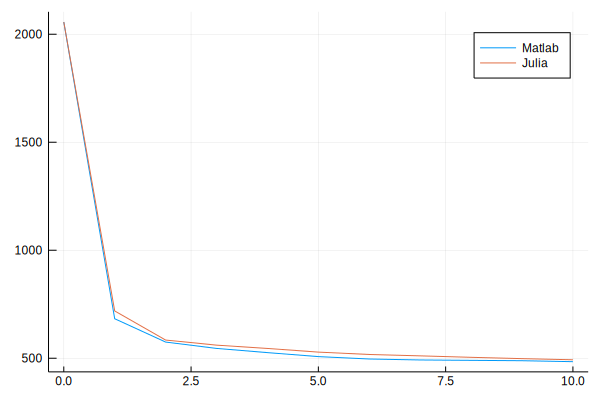

In [113]:
@mget cost_alcg
plot(0:10, cost_alcg[:], label="Matlab")
plot!(0:10, collect(j_cost_cg), label="Julia")

### Run AL-2
#### Matlab code

In [114]:
mat"""
d1 = 1/10; d2 = 1/100;  %for AL-2
"""
@time eval_string("[L_al2,S_al2,xdiff_al2,cost_al2,time_al2,rankL_al2] = AL_2(opt,'d1',d1,'d2',d2);")

>>  ite: 0, xdiff: 111.1760183, cost: 2056.6478743, rank of L: 24
 ********** AL-2: L+S reconstruction **********
 ite: 1 , rank of L: 1, xdiff: 95.6885453, cost: 2365.8748573
 ite: 2 , rank of L: 1, xdiff: 65.7433623, cost: 798.3235803
 ite: 3 , rank of L: 0, xdiff: 53.3320393, cost: 413.0994443
 ite: 4 , rank of L: 0, xdiff: 46.7413293, cost: 323.3674703
 ite: 5 , rank of L: 0, xdiff: 41.2476313, cost: 289.0024733
 ite: 6 , rank of L: 0, xdiff: 36.6471563, cost: 269.1716313
 ite: 7 , rank of L: 0, xdiff: 33.0463753, cost: 258.1183483
 ite: 8 , rank of L: 0, xdiff: 30.2602373, cost: 251.8830083
 ite: 9 , rank of L: 0, xdiff: 28.1066283, cost: 248.0244133
 ite: 10 , rank of L: 0, xdiff: 26.4248773, cost: 245.1701213
 67.286817 seconds (23 allocations: 1.250 KiB)


#### Julia equivalent

In [115]:
@time L, S, j_cost_al = AL_2(kdata, Ω, Q, C, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025, δ₁ = 1/10., δ₂ = 1/100.);

k = 0, rank = 24, cost = 2056.647874472908
k = 1, rank = 1, cost = 2365.874856786227
k = 2, rank = 1, cost = 798.3235798359939
k = 3, rank = 0, cost = 413.0994435770355
k = 4, rank = 0, cost = 323.36746952367594
k = 5, rank = 0, cost = 289.00247283524646
k = 6, rank = 0, cost = 269.17163082978766
k = 7, rank = 0, cost = 258.11834791211504
k = 8, rank = 0, cost = 251.88300763062585
k = 9, rank = 0, cost = 248.02441250687525
k = 10, rank = 0, cost = 245.17012076300148
127.667912 seconds (17.08 k allocations: 168.084 GiB, 26.72% gc time)


#### Comparism

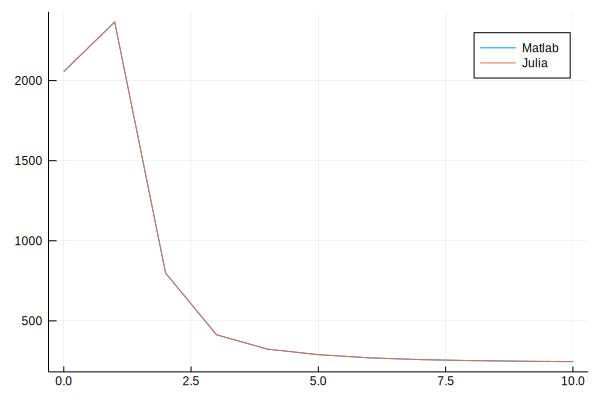

In [116]:
@mget cost_al2
plot(0:10, cost_al2[:], label="Matlab")
plot!(0:10, collect(j_cost_al), label="Julia")

### Run ISTA
#### Matlab code

In [117]:
mat"""
param.E=getE(b1c,nt,'samp',kdata(:,:,:,1)~=0);
param.d=kdata;
param.T = getT(nx,ny,nt);
param.nite=10;
param.scaleL = 175/1.2656;
param.scaleS = 1/1.2656;
param.lambda_L=0.01;
param.lambda_S=0.0025*param.scaleS;
param.Xinf = reshape(Xinf.cine,nx*ny,nt);
"""
@time eval_string("[L_ista,S_ista,xdiff_ista,cost_ista,time_ista,rankL_ista] = PGM(param);")

>>  ite: 0, xdiff: 111.1760183, cost: 2056.6478743, rank of L: 24
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 24, xdiff: 77.2504503, cost: 931.0880953
 ite: 2, rank of L: 24, xdiff: 67.1571043, cost: 782.0542613
 ite: 3, rank of L: 24, xdiff: 60.1077463, cost: 709.3672743
 ite: 4, rank of L: 24, xdiff: 54.7802243, cost: 658.1694593
 ite: 5, rank of L: 23, xdiff: 50.2011303, cost: 617.5562673
 ite: 6, rank of L: 21, xdiff: 46.3694113, cost: 584.0904523
 ite: 7, rank of L: 19, xdiff: 42.9700513, cost: 556.4205143
 ite: 8, rank of L: 16, xdiff: 40.0760083, cost: 533.0474603
 ite: 9, rank of L: 15, xdiff: 37.5284423, cost: 513.8099193
 ite: 10, rank of L: 13, xdiff: 35.3816603, cost: 498.0421783
  7.399567 seconds (23 allocations: 1.250 KiB)


#### Julia equivalent

In [118]:
@time L, S, j_cost_ista = PGM(kdata, E, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025, momentum=:ista);

k = 0, rank = 24, cost = 2056.647874472908
k = 1, rank = 24, cost = 930.4312103123665
k = 2, rank = 24, cost = 781.2870933272604
k = 3, rank = 24, cost = 708.2692299050346
k = 4, rank = 24, cost = 656.894970651201
k = 5, rank = 23, cost = 616.1078014067639
k = 6, rank = 21, cost = 582.5971010758693
k = 7, rank = 19, cost = 554.901301724845
k = 8, rank = 16, cost = 531.6109624458345
k = 9, rank = 15, cost = 512.4119700464813
k = 10, rank = 13, cost = 496.76300884217255
 78.211946 seconds (14.66 k allocations: 112.877 GiB, 9.68% gc time)


#### Comparism

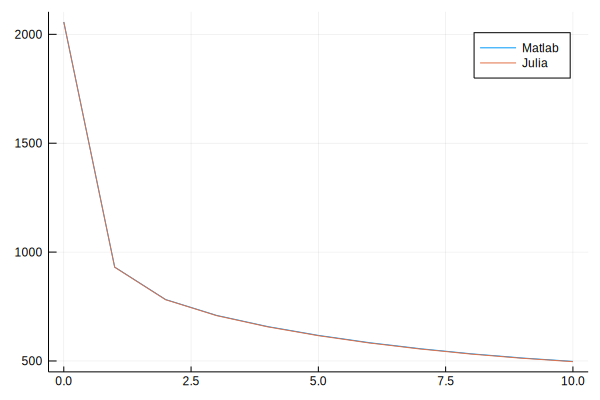

In [119]:
@mget cost_ista
plot(0:10, cost_ista[:], label="Matlab")
plot!(0:10, collect(j_cost_ista), label="Julia")

### Run FISTA
#### Matlab code

In [120]:
@time eval_string("[L_fista,S_fista,xdiff_fista,cost_fista,time_fista,rankL_fista] = PGM(param,'fistaL',1,'fistaS',1);")

>>  ite: 0, xdiff: 111.1760183, cost: 2056.6478743, rank of L: 24
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 24, xdiff: 89.7275773, cost: 1203.0921193
 ite: 2, rank of L: 24, xdiff: 79.3396383, cost: 952.7407733
 ite: 3, rank of L: 24, xdiff: 71.1560133, cost: 821.6829323
 ite: 4, rank of L: 24, xdiff: 64.3450703, cost: 743.5552883
 ite: 5, rank of L: 24, xdiff: 58.3090363, cost: 686.0264113
 ite: 6, rank of L: 24, xdiff: 52.7729383, cost: 637.1883603
 ite: 7, rank of L: 23, xdiff: 47.6568833, cost: 593.8171413
 ite: 8, rank of L: 20, xdiff: 42.9705733, cost: 555.9679033
 ite: 9, rank of L: 16, xdiff: 38.7736433, cost: 523.7240033
 ite: 10, rank of L: 13, xdiff: 35.1568373, cost: 497.8138393
 13.330252 seconds (23 allocations: 1.250 KiB)


#### Julia equivalent

In [121]:
@time L, S, j_cost_fista = PGM(kdata, E, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025, momentum=:fista);

k = 0, rank = 24, cost = 2056.647874472908
k = 1, rank = 24, cost = 1194.5046364630036
k = 2, rank = 24, cost = 867.4907072913427
k = 3, rank = 24, cost = 719.6949117587621
k = 4, rank = 21, cost = 628.2099818643835
k = 5, rank = 16, cost = 561.2862388495164
k = 6, rank = 11, cost = 512.7819816924691
k = 7, rank = 7, cost = 481.37389033887433
k = 8, rank = 4, cost = 462.6272213193005
k = 9, rank = 3, cost = 450.5970221698689
k = 10, rank = 2, cost = 442.7460670541386
 74.019757 seconds (14.72 k allocations: 112.877 GiB, 8.74% gc time)


In [122]:
@time L, S, j_cost_fista2 = FISTA(kdata, E, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025);

k = 0, rank = 24, cost = 2056.647874472908
k = 1, rank = 24, cost = 1203.0921190761378
k = 2, rank = 24, cost = 952.7407729492534
k = 3, rank = 24, cost = 821.6829321734339
k = 4, rank = 24, cost = 743.5552880060544
k = 5, rank = 24, cost = 686.0264108322413
k = 6, rank = 24, cost = 637.1883604625937
k = 7, rank = 23, cost = 593.81714138225
k = 8, rank = 20, cost = 555.9679029038375
k = 9, rank = 16, cost = 523.7240033622168
k = 10, rank = 13, cost = 497.8138387079109
 72.352833 seconds (14.70 k allocations: 114.728 GiB, 7.08% gc time)


#### Comparism

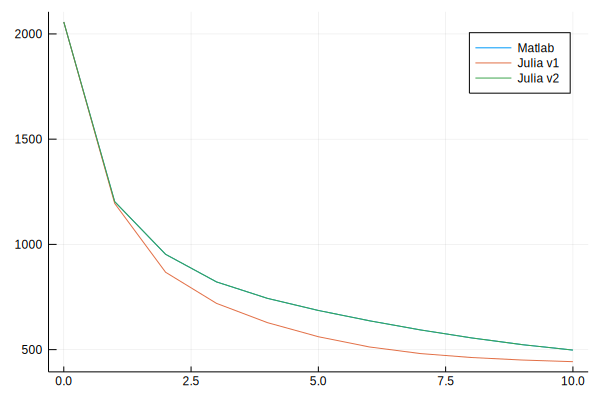

In [123]:
@mget cost_fista
plot(0:10, cost_fista[:], label="Matlab")
plot!(0:10, collect(j_cost_fista), label="Julia v1")
plot!(0:10, collect(j_cost_fista2), label="Julia v2")

The difference here is due to difference locations where cost function evaluated inside an iteration, and also the different ordering of steps. "Julia v1" is the FISTA variant of the general `PGM` method, and thus executes the steps of FISTA in the same order as ISTA and POGM, and evaluates the cost function in the end of the iteration. On the other hand, "Julia v2" follows the description of FISTA algorithm in the referenced paper (and thus also the Matlab implementation), therefore it reproduces successfully the results of the paper.

### Run POGM
#### Matlab code

In [124]:
@time eval_string("[L_pogm,S_pogm,xdiff_pogm,cost_pogm,time_pogm,rankL_pogm] = PGM(param,'pogmS',1,'pogmL',1);")

>>  ite: 0, xdiff: 111.1760183, cost: 2056.6478743, rank of L: 24
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 24, xdiff: 80.6012043, cost: 968.3333903
 ite: 2, rank of L: 24, xdiff: 67.3216093, cost: 779.9223193
 ite: 3, rank of L: 24, xdiff: 57.6739773, cost: 686.7232793
 ite: 4, rank of L: 23, xdiff: 49.5012823, cost: 613.9794813
 ite: 5, rank of L: 19, xdiff: 42.4597663, cost: 555.2589473
 ite: 6, rank of L: 14, xdiff: 36.5725523, cost: 509.8669403
 ite: 7, rank of L: 8, xdiff: 32.0292363, cost: 479.2692883
 ite: 8, rank of L: 5, xdiff: 28.7907943, cost: 461.0693393
 ite: 9, rank of L: 3, xdiff: 26.4333953, cost: 449.8849533
 ite: 10, rank of L: 3, xdiff: 24.9634973, cost: 442.2500543
  8.958268 seconds (23 allocations: 1.250 KiB)


#### Julia equivalent

In [125]:
@time L, S, j_cost_pogm = PGM(kdata, E, T, scale_L = 175/1.2656, scale_S = 1/1.2656,
    λ_L = 0.01, λ_S = 0.0025, momentum=:pogm);

k = 0, rank = 24, cost = 2056.647874472908
k = 1, rank = 24, cost = 959.6629169195465
k = 2, rank = 24, cost = 772.3458365275912
k = 3, rank = 24, cost = 684.7385463571809
k = 4, rank = 24, cost = 619.0335959938658
k = 5, rank = 21, cost = 566.4411873424801
k = 6, rank = 16, cost = 524.8217275408305
k = 7, rank = 13, cost = 493.36348319570584
k = 8, rank = 8, cost = 472.5625969110671
k = 9, rank = 5, cost = 459.08235043312294
k = 10, rank = 3, cost = 450.52495837284204
 75.401795 seconds (14.84 k allocations: 112.877 GiB, 8.91% gc time)


#### Comparism

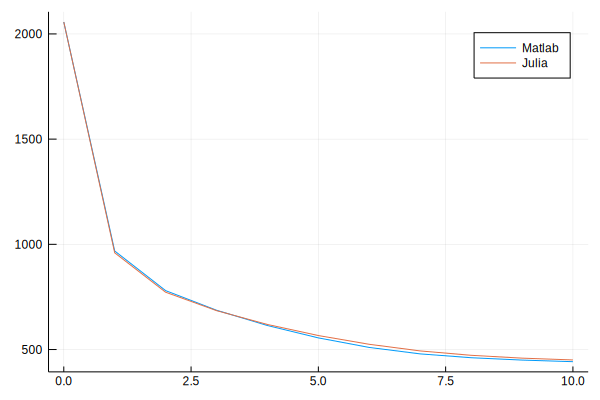

In [126]:
@mget cost_pogm
plot(0:10, cost_pogm[:], label="Matlab")
plot!(0:10, collect(j_cost_pogm), label="Julia")

## Show POGM result

┌ Warning: magnitude at none 0 #jim(): 
└ @ MIRT /home/hakkelt/.julia/packages/MIRT/013iB/src/plot/jim.jl:130


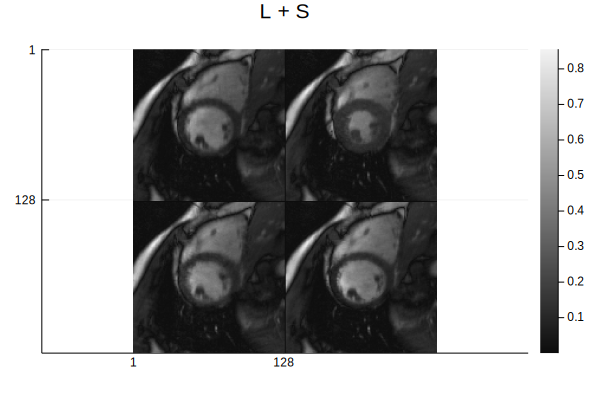

In [127]:
LplusS = L + S
LplusSd = cat(LplusS[65:192,65:192,2], LplusS[65:192,65:192,8], LplusS[65:192,65:192,14], LplusS[65:192,65:192,20], dims=3);
jim(LplusSd, "L + S")

┌ Warning: magnitude at none 0 #jim(): 
└ @ MIRT /home/hakkelt/.julia/packages/MIRT/013iB/src/plot/jim.jl:130


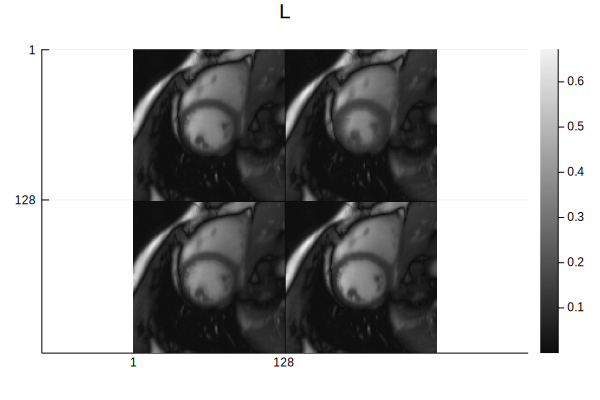

In [128]:
Ld = cat(L[65:192,65:192,2], L[65:192,65:192,8], L[65:192,65:192,14], L[65:192,65:192,20], dims=3);
jim(Ld, "L")

┌ Warning: magnitude at none 0 #jim(): 
└ @ MIRT /home/hakkelt/.julia/packages/MIRT/013iB/src/plot/jim.jl:130


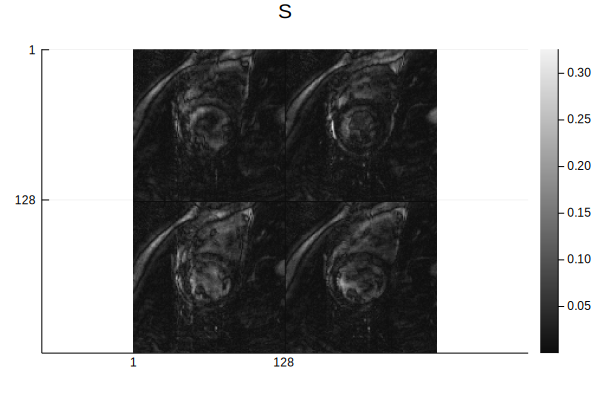

In [129]:
Sd = cat(S[65:192,65:192,2], S[65:192,65:192,8], S[65:192,65:192,14], S[65:192,65:192,20], dims=3);
jim(Sd, "S")

# Multicoil cardiac perfusion MRI
https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/examples/example_cardiac_perf.m

## Preparation

### Read data
#### Matlab code

In [81]:
mat"""
% L+S reconstruction of undersampled multicoil cardiac perfusion MRI
% Claire Lin, 05/20/2018
clear all;close all;
load('../reproduce-l-s-dynamic-mri/data/cardiac_perf_R8.mat')
load('../reproduce-l-s-dynamic-mri/data/Xinf.mat')
%% normalize smap
[nx,ny,nt,nc]=size(kdata);
tmp = sqrt(sum(abs((b1)).^2,3));
b1c = div0(b1,tmp);
"""

>> 


#### Julia equivalent

┌ Warning: magnitude at jim.jl 129 jim(): 
└ @ MIRT /home/hakkelt/.julia/packages/MIRT/013iB/src/plot/jim.jl:130


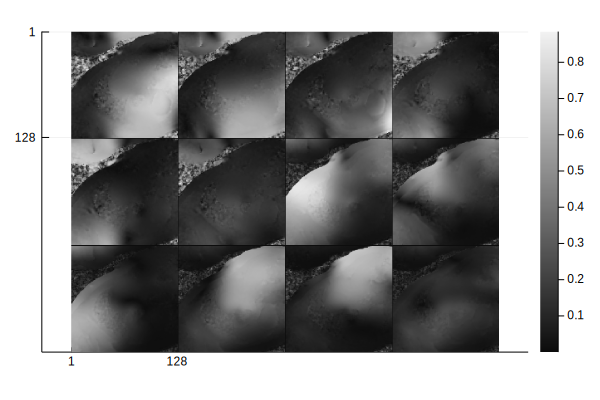

In [82]:
data = matread("../reproduce-l-s-dynamic-mri/data/cardiac_perf_R8.mat")
kdata, b1 = data["kdata"], data["b1"]
nx,ny,nt,nc = size(kdata)
b1c = b1 ./ sqrt.(sum(abs2, b1, dims=3))
jim(b1c)

Sampling pattern:

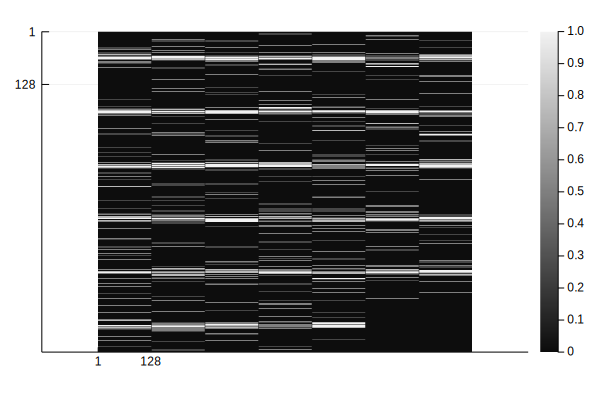

In [83]:
samp = kdata[:,:,:,1] .!= 0
jim(samp)

In [84]:
E = getE(nx, ny, nt, nc, Float64.(samp), b1c)
Ω, Q, C = getΩQC(nx, ny, nt, nc, Float64.(samp), b1c)
T = getT(nx,ny,nt)

LinearMaps.FunctionMap{Complex{Float32}}(#26, #27, 655360, 655360; ismutating=false, issymmetric=false, ishermitian=false, isposdef=false)

## Test algorithms

### Run AL-CG
#### Matlab code

In [85]:
mat"""
%% prepare for AL: opt
opt.d = kdata;
opt.smap = b1c;
opt.T=getT(nx,ny,nt);
opt.nite = 10;
opt.samp = opt.d(:,:,:,1)~=0;
[opt.F,opt.C] = getFS(opt.smap,nt,'samp',opt.samp);
opt.E=getE(b1c,nt,'samp',opt.samp);
% scalers to match Otazo's results
opt.scaleL = 130/1.2775; % Otazo's stopping St(1) / b1 constant squared
opt.scaleS = 1/1.2775; % 1 / b1 constant squared
opt.muL=0.01;
opt.muS=0.01*opt.scaleS;
opt.Xinf = Xinf.perf;
%% AL-CG
d1 = 1/5; d2 = 1/5; %for AL-CG
"""

In [86]:
@time eval_string("[L_cg,S_cg,x_cg,cost_cg,time_cg,rankL_cg] = AL_CG(opt,'d1',d1,'d2',d2);") 

>>  ite: 0, xdiff: 118.9517593, cost: 1605.9090993, rank of L: 40
 ********** AL-CG: L+S reconstruction **********
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 0.0018.
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 0.0068.
 ite: 1 , rank of L: 40, xdiff: 81.4396513, cost: 677.7361773
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 0.00054.
cgs stopped at iteration 3 without converging to the desired tolerance 1e-05
because the maximum number of iterations was reached.
The iterate returned (number 3) has relative residual 0.0045.
 ite: 2 , rank of L: 40, xdiff: 63.3424423, cost: 

#### Julia equivalent

In [87]:
@time L, S, j_cost_cg = AL_CG(kdata, E, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, δ₁ = 1/5., δ₂ = 1/5.);

k = 0, rank = 40, cost = 1605.909098593456
k = 1, rank = 40, cost = 685.8410743871787
k = 2, rank = 40, cost = 585.7224251200577
k = 3, rank = 40, cost = 532.0409719803744
k = 4, rank = 40, cost = 500.1502294025963
k = 5, rank = 40, cost = 481.3943380359724
k = 6, rank = 40, cost = 469.2251373905215
k = 7, rank = 40, cost = 460.37132605131274
k = 8, rank = 40, cost = 453.4819120097597
k = 9, rank = 40, cost = 448.24986190079903
k = 10, rank = 40, cost = 444.43165804362343
138.915114 seconds (74.66 k allocations: 268.922 GiB, 3.96% gc time)


#### Comparism

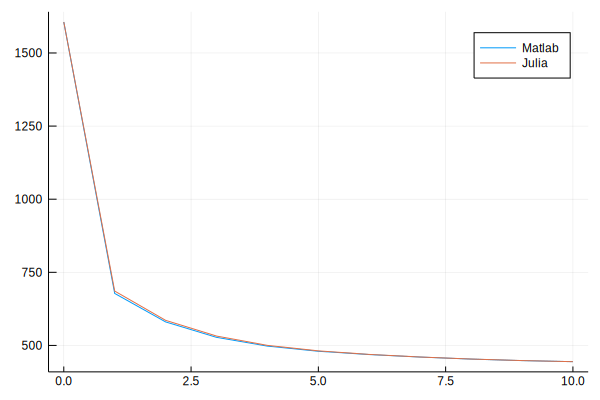

In [90]:
@mget cost_cg
plot(0:10, cost_cg[:], label="Matlab")
plot!(0:10, collect(j_cost_cg), label="Julia")

### Run AL-2
#### Matlab code

In [89]:
mat"""
d1 = 1/5; d2 = 1/50; %for AL-2
"""
@time eval_string("[L_al,S_al,xdiff_al,cost_al,time_al,rankL_al] = AL_2(opt,'d1',d1,'d2',d2);")

>>  ite: 0, xdiff: 118.9517593, cost: 1605.9090993, rank of L: 40
 ********** AL-2: L+S reconstruction **********
 ite: 1 , rank of L: 1, xdiff: 118.0958713, cost: 2919.1098513
 ite: 2 , rank of L: 1, xdiff: 89.0041583, cost: 1310.4811123
 ite: 3 , rank of L: 3, xdiff: 77.6117863, cost: 820.5040173
 ite: 4 , rank of L: 3, xdiff: 70.6298073, cost: 642.2338453
 ite: 5 , rank of L: 4, xdiff: 64.0606163, cost: 552.3495333
 ite: 6 , rank of L: 5, xdiff: 58.0906793, cost: 500.7592743
 ite: 7 , rank of L: 5, xdiff: 52.7845843, cost: 469.7612703
 ite: 8 , rank of L: 4, xdiff: 48.1143843, cost: 450.6305853
 ite: 9 , rank of L: 4, xdiff: 44.0771873, cost: 438.6039523
 ite: 10 , rank of L: 4, xdiff: 40.6270413, cost: 430.6803203
 33.379970 seconds (23 allocations: 1.250 KiB)


#### Julia equivalent

In [91]:
@time L, S, j_cost_al = AL_2(kdata, Ω, Q, C, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, δ₁ = 1/5., δ₂ = 1/50.);

k = 0, rank = 40, cost = 1605.909098593456
k = 1, rank = 1, cost = 2919.1098506360163
k = 2, rank = 1, cost = 1310.481111764494
k = 3, rank = 3, cost = 820.5040168998145
k = 4, rank = 3, cost = 642.2338446919767
k = 5, rank = 4, cost = 552.3495333501066
k = 6, rank = 5, cost = 500.7592743815686
k = 7, rank = 5, cost = 469.76127007080004
k = 8, rank = 4, cost = 450.6305849877622
k = 9, rank = 4, cost = 438.60395228154067
k = 10, rank = 4, cost = 430.6803200785823
 39.364616 seconds (446.35 k allocations: 70.057 GiB, 9.73% gc time)


#### Comparism

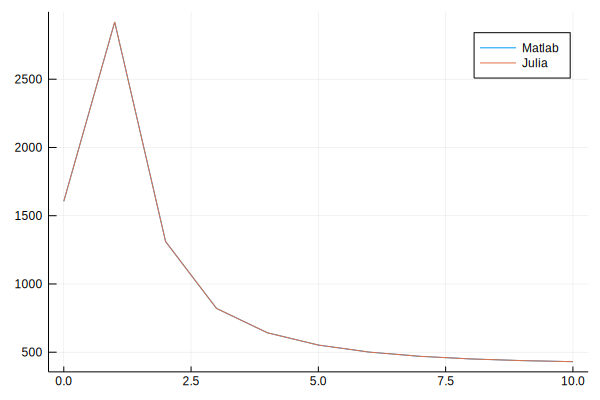

In [92]:
@mget cost_al
plot(0:10, cost_al[:], label="Matlab")
plot!(0:10, collect(j_cost_al), label="Julia")

### Run ISTA
#### Matlab code

In [93]:
mat"""
param.E=getE(b1c,nt,'samp',kdata(:,:,:,1)~=0);
param.d=kdata;
param.T = getT(nx,ny,nt);
param.nite=10;
param.scaleL = 130/1.2775;
param.scaleS = 1/1.2775;
param.lambda_L=0.01;
param.lambda_S=0.01*param.scaleS;
param.Xinf = reshape(Xinf.perf,nx*ny,nt);
"""
@time eval_string("[L_ista,S_ista,xdiff_ista,cost_ista,time_ista,rankL_ista] = PGM(param);")

>>  ite: 0, xdiff: 118.9517593, cost: 1605.9090993, rank of L: 40
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 40, xdiff: 94.7225423, cost: 819.4575223
 ite: 2, rank of L: 40, xdiff: 86.7924423, cost: 707.9456013
 ite: 3, rank of L: 40, xdiff: 80.7610023, cost: 651.7363823
 ite: 4, rank of L: 40, xdiff: 75.9018943, cost: 612.8571323
 ite: 5, rank of L: 38, xdiff: 71.5280463, cost: 583.2456303
 ite: 6, rank of L: 36, xdiff: 67.6884923, cost: 559.7511453
 ite: 7, rank of L: 33, xdiff: 64.1339653, cost: 540.6652673
 ite: 8, rank of L: 29, xdiff: 60.9227943, cost: 524.8275273
 ite: 9, rank of L: 28, xdiff: 57.9282653, cost: 511.4539013
 ite: 10, rank of L: 27, xdiff: 55.1851813, cost: 499.9599543
  3.532584 seconds (23 allocations: 1.250 KiB)


#### Julia equivalent

In [94]:
@time L, S, j_cost_ista = PGM(kdata, E, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, momentum=:ista);

k = 0, rank = 40, cost = 1605.909098593456
k = 1, rank = 40, cost = 818.9382257398152
k = 2, rank = 40, cost = 707.3174310720532
k = 3, rank = 40, cost = 650.9061843089734
k = 4, rank = 40, cost = 611.9376380902601
k = 5, rank = 37, cost = 582.2882165942873
k = 6, rank = 35, cost = 558.7976569091929
k = 7, rank = 32, cost = 539.724993910255
k = 8, rank = 29, cost = 523.9214778076409
k = 9, rank = 28, cost = 510.5637410924892
k = 10, rank = 27, cost = 499.0950426361329
 25.692236 seconds (38.90 k allocations: 47.035 GiB, 2.85% gc time)


#### Comparism

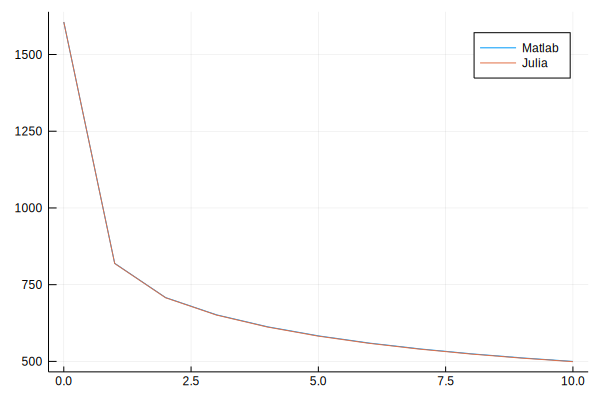

In [95]:
@mget cost_ista
plot(0:10, cost_ista[:], label="Matlab")
plot!(0:10, collect(j_cost_ista), label="Julia")

### Run FISTA
#### Matlab code

In [96]:
@time eval_string("[L_fista,S_fista,xdiff_fista,cost_fista,time_fista,rankL_fista] = PGM(param,'fistaL',1,'fistaS',1);")

>>  ite: 0, xdiff: 118.9517593, cost: 1605.9090993, rank of L: 40
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 40, xdiff: 103.8934403, cost: 1016.8542883
 ite: 2, rank of L: 40, xdiff: 96.2738423, cost: 836.7154403
 ite: 3, rank of L: 40, xdiff: 89.9116443, cost: 738.6073813
 ite: 4, rank of L: 40, xdiff: 84.2732853, cost: 678.2913103
 ite: 5, rank of L: 40, xdiff: 78.9840853, cost: 633.9038893
 ite: 6, rank of L: 40, xdiff: 73.8725053, cost: 597.3557363
 ite: 7, rank of L: 37, xdiff: 68.8839953, cost: 566.2765563
 ite: 8, rank of L: 33, xdiff: 64.0132223, cost: 539.8553613
 ite: 9, rank of L: 29, xdiff: 59.2761233, cost: 517.4710143
 ite: 10, rank of L: 27, xdiff: 54.7063873, cost: 498.4585513
  4.919465 seconds (23 allocations: 1.250 KiB)


#### Julia equivalent

In [97]:
@time L, S, j_cost_fista = PGM(kdata, E, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, momentum=:fista);

k = 0, rank = 40, cost = 1605.909098593456
k = 1, rank = 40, cost = 1032.1930042184888
k = 2, rank = 40, cost = 791.3130558953426
k = 3, rank = 37, cost = 675.5737791051612
k = 4, rank = 30, cost = 607.1623694661109
k = 5, rank = 26, cost = 559.9893293239435
k = 6, rank = 21, cost = 524.7777031745583
k = 7, rank = 18, cost = 497.4652478195104
k = 8, rank = 15, cost = 476.2997646290817
k = 9, rank = 13, cost = 460.13768157542665
k = 10, rank = 11, cost = 450.24524008138076
 26.036985 seconds (14.73 k allocations: 47.034 GiB, 4.12% gc time)


In [98]:
@time L, S, j_cost_fista2 = FISTA(kdata, E, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01);

k = 0, rank = 40, cost = 1605.909098593456
k = 1, rank = 40, cost = 1016.8542876968228
k = 2, rank = 40, cost = 836.7154400307954
k = 3, rank = 40, cost = 738.6073814091724
k = 4, rank = 40, cost = 678.2913101041321
k = 5, rank = 40, cost = 633.9038893032842
k = 6, rank = 40, cost = 597.3557362371577
k = 7, rank = 37, cost = 566.2765559548463
k = 8, rank = 33, cost = 539.8553609472558
k = 9, rank = 29, cost = 517.4710142603794
k = 10, rank = 27, cost = 498.45855111011514
 25.534144 seconds (28.26 k allocations: 47.806 GiB, 2.07% gc time)


#### Comparism

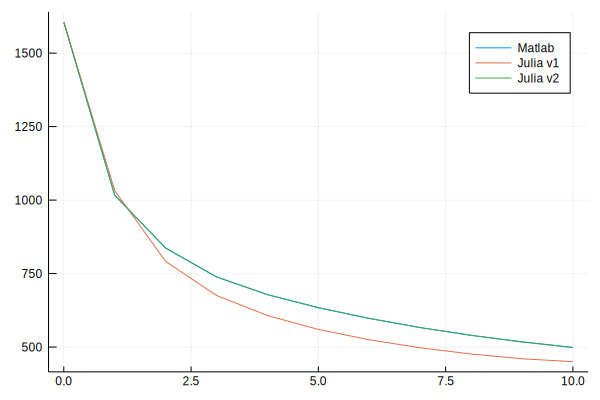

In [99]:
@mget cost_fista
plot(0:10, cost_fista[:], label="Matlab")
plot!(0:10, collect(j_cost_fista), label="Julia v1")
plot!(0:10, collect(j_cost_fista2), label="Julia v2")

The difference here is due to difference locations where cost function evaluated inside an iteration, and also the different ordering of steps. "Julia v1" is the FISTA variant of the general `PGM` method, and thus executes the steps of FISTA in the same order as ISTA and POGM, and evaluates the cost function in the end of the iteration. On the other hand, "Julia v2" follows the description of FISTA algorithm in the referenced paper (and thus also the Matlab implementation), therefore it reproduces successfully the results of the paper.

### Run POGM
#### Matlab code

In [100]:
@time eval_string("[L_pogm,S_pogm,xdiff_pogm,cost_pogm,time_pogm,rankL_pogm] = PGM(param,'pogmS',1,'pogmL',1);")

>>  ite: 0, xdiff: 118.9517593, cost: 1605.9090993, rank of L: 40
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 40, xdiff: 97.3583763, cost: 849.4886573
 ite: 2, rank of L: 40, xdiff: 86.9139863, cost: 707.7278993
 ite: 3, rank of L: 40, xdiff: 78.6276933, cost: 635.4357403
 ite: 4, rank of L: 37, xdiff: 71.0008163, cost: 580.9478443
 ite: 5, rank of L: 32, xdiff: 63.7240603, cost: 539.0874053
 ite: 6, rank of L: 28, xdiff: 56.7864073, cost: 506.9395343
 ite: 7, rank of L: 22, xdiff: 50.2903563, cost: 481.9811793
 ite: 8, rank of L: 19, xdiff: 44.3746223, cost: 462.8262993
 ite: 9, rank of L: 16, xdiff: 39.1518293, cost: 448.2832673
 ite: 10, rank of L: 13, xdiff: 35.6455923, cost: 439.4732693
  3.459792 seconds (23 allocations: 1.250 KiB)


#### Julia equivalent

In [101]:
@time L, S, j_cost_pogm = PGM(kdata, E, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, momentum=:pogm);

k = 0, rank = 40, cost = 1605.909098593456
k = 1, rank = 40, cost = 845.719650195784
k = 2, rank = 40, cost = 701.5183219597353
k = 3, rank = 40, cost = 634.7228529222214
k = 4, rank = 40, cost = 585.6027816423962
k = 5, rank = 36, cost = 547.4927072431932
k = 6, rank = 31, cost = 517.9527494800777
k = 7, rank = 28, cost = 494.6522220980837
k = 8, rank = 24, cost = 476.00986965246165
k = 9, rank = 21, cost = 461.29638034080403
k = 10, rank = 18, cost = 450.22377485651526
 25.582721 seconds (14.85 k allocations: 47.034 GiB, 1.91% gc time)


#### Comparism

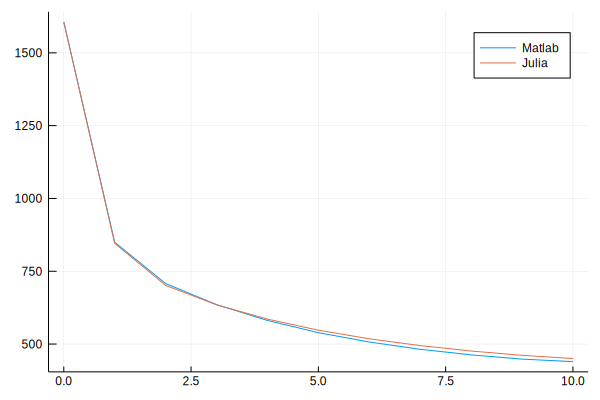

In [102]:
@mget cost_pogm
plot(0:10, cost_pogm[:], label="Matlab")
plot!(0:10, collect(j_cost_pogm), label="Julia")

## Show POGM result

┌ Warning: magnitude at none 0 #jim(): 
└ @ MIRT /home/hakkelt/.julia/packages/MIRT/013iB/src/plot/jim.jl:130


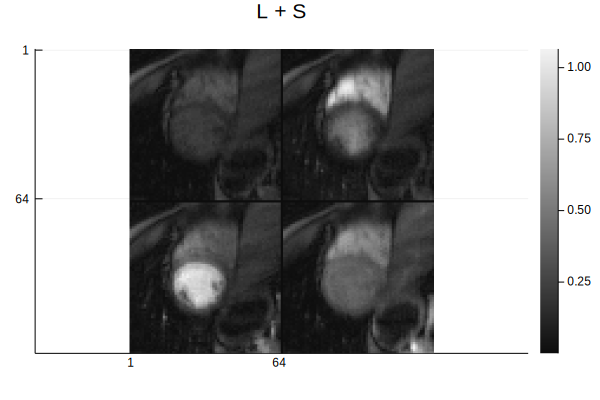

In [103]:
LplusS = L + S
LplusSd = cat(LplusS[33:96,33:96,2], LplusS[33:96,33:96,8], LplusS[33:96,33:96,14], LplusS[33:96,33:96,24], dims=3);
jim(LplusSd, "L + S")

┌ Warning: magnitude at none 0 #jim(): 
└ @ MIRT /home/hakkelt/.julia/packages/MIRT/013iB/src/plot/jim.jl:130


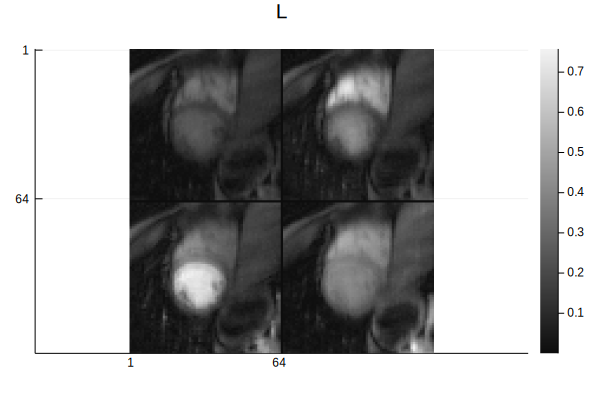

In [104]:
Ld = cat(L[33:96,33:96,2], L[33:96,33:96,8], L[33:96,33:96,14], L[33:96,33:96,24], dims=3);
jim(Ld, "L")

┌ Warning: magnitude at none 0 #jim(): 
└ @ MIRT /home/hakkelt/.julia/packages/MIRT/013iB/src/plot/jim.jl:130


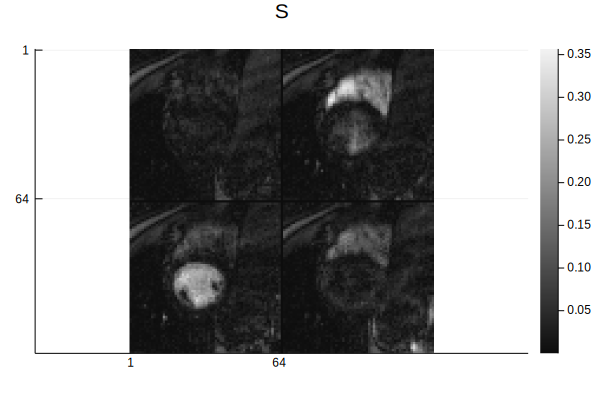

In [105]:
Sd = cat(S[33:96,33:96,2], S[33:96,33:96,8], S[33:96,33:96,14], S[33:96,33:96,24], dims=3);
jim(Sd, "S")

# Multicoil abdominal dce MRI
https://github.com/JeffFessler/reproduce-l-s-dynamic-mri/blob/master/examples/example_abdomen_dce_ga.m

## Preparation

### Read data
#### Matlab code

In [118]:
mat"""
% L+S reconstruction of undersampled multicoil abdominal dce MRI
% Claire Lin, 05/07/2019
clear all;close all;
load('../reproduce-l-s-dynamic-mri/data/abdomen_dce_ga.mat')
load ('../reproduce-l-s-dynamic-mri/data/Xinf.mat')
%% number of spokes to be used per frame (Fibonacci number)
nspokes=21;
[nx,ny,nc]=size(b1);
[nr,ntviews,nc]=size(kdata);
% number of frames
nt=floor(ntviews/nspokes);
% crop the data according to the number of spokes per frame
kdata=kdata(:,1:nt*nspokes,:);
k=k(:,1:nt*nspokes);
w=w(:,1:nt*nspokes);
% sort the data into a time-series of undersampled images
for ii=1:nt
    kdatau(:,:,:,ii)=kdata(:,(ii-1)*nspokes+1:ii*nspokes,:);
    ku(:,:,ii)=k(:,(ii-1)*nspokes+1:ii*nspokes);
    wu(:,:,ii)=w(:,(ii-1)*nspokes+1:ii*nspokes);
end
%% normalize smap
tmp = sqrt(sum(abs((b1)).^2,3));
b1c = div0(b1,tmp);
%% prepare for system operator
ksp = reshape(ku,[],nt); 
ksp3(:,1,:) = real(ksp);
ksp3(:,2,:) = imag(ksp);
om3 = ksp3*2*pi;
wi3 = reshape(wu,[],nt);
M = size(ksp,1);
"""

#### Julia equivalent

┌ Warning: magnitude at jim.jl 129 jim(): 
└ @ MIRT /home/hakkelt/.julia/packages/MIRT/013iB/src/plot/jim.jl:130


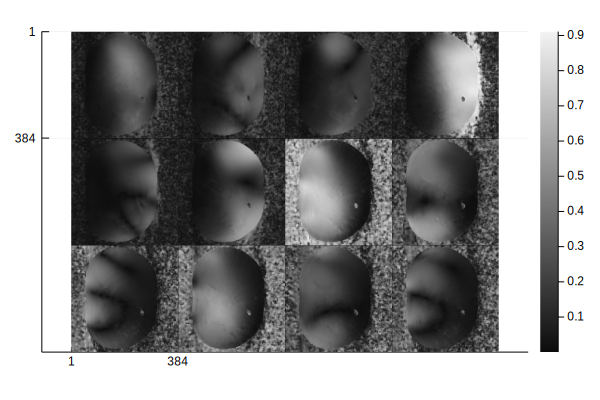

In [36]:
data = matread("../reproduce-l-s-dynamic-mri/data/abdomen_dce_ga.mat")
w, kdata, k, b1 = data["w"], data["kdata"], data["k"], data["b1"]
nspokes = 21 # number of spokes to be used per frame (Fibonacci number)
nx,ny,nc = size(b1)
nr,ntviews,nc = size(kdata)
nt = ntviews ÷ nspokes # number of frames

# crop the data according to the number of spokes per frame:
kdata = kdata[:,1:nt*nspokes,:]
k = k[:,1:nt*nspokes]
w = w[:,1:nt*nspokes]

# sort the data into a time-series of undersampled images:
kdatau = Array{Complex{Float64}}(undef, nr, nspokes, nc, nt)
ku = Array{Complex{Float64}}(undef, nr, nspokes, nt)
wu = Array{Complex{Float64}}(undef, nr, nspokes, nt)
for ii = 1:nt
    kdatau[:,:,:,ii] = kdata[:,(ii-1)*nspokes+1:ii*nspokes,:]
    ku[:,:,ii] = k[:,(ii-1)*nspokes+1:ii*nspokes]
    wu[:,:,ii] = w[:,(ii-1)*nspokes+1:ii*nspokes]
end

# prepare for system operator
ksp = reshape(ku, nr*nspokes, nt)
ksp3 = Array{Complex{Float64}}(undef, nr*nspokes, 2, nt)
ksp3[:,1,:] = real(ksp)
ksp3[:,2,:] = imag(ksp)
om3 = ksp3*2*pi
wi3 = reshape(wu, nr*nspokes, nt)
M = size(ksp,1)

# normalize smap
b1c = b1 ./ sqrt.(sum(abs2, b1, dims=3))
jim(b1c)

## Test algorithms

In [162]:
mat"""
%% prepare for PGM: param
param.E = getEnufft(b1c,nt,'M',M,'ksp',ksp3,'om',om3,'wi',wi3,'donufft',1);
param.d=permute(reshape(kdatau,[],nc,nt),[1 3 2]);
recon_nufft=param.E'*param.d;
"""

In [183]:
E = getEnufft(b1c, ksp=ksp3, om=Float64.(om3), wi=wi3)
d = permutedims(reshape(kdatau,nx*nspokes,nc,nt), [1 3 2])
recon_nufft = E' * d[:]
T = getT(nx,ny,nt)

LinearMaps.FunctionMap{Complex{Float32}}(#26, #27, 4128768, 4128768; ismutating=false, issymmetric=false, ishermitian=false, isposdef=false)

Check if the Matlab and Julia versions produce the same result

In [177]:
eval_string("m_recon_nufft = recon_nufft;")
@mget m_recon_nufft
maximum(abs, m_recon_nufft[:] - recon_nufft)

9.714722772122077e-8

### Run ISTA
#### Matlab code

In [182]:
mat"""
tscale = 1.3002; %power iteration on E'E
param.scaleL = 0.0274/1.099;
param.scaleS = 1/1.099;
param.lambda_L=0.025;
param.lambda_S=0.5*max(abs(recon_nufft(:)))*param.scaleS;
param.nite=10;
param.tol=0.0025;
param.T= getT(nx,ny,nt);
param.Xinf = reshape(Xinf.abd,nx*ny,nt);
"""
@time eval_string("[L_ista,S_ista,xdiff_ista,cost_ista,time_ista,rankL_ista] = PGM(param,'tscale',tscale);")

>>  ite: 0, xdiff: 0.1836113, cost: 0.1563813, rank of L: 28
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 28, xdiff: 0.1589423, cost: 0.1228233
 ite: 2, rank of L: 28, xdiff: 0.1390143, cost: 0.0988193
 ite: 3, rank of L: 28, xdiff: 0.1228113, cost: 0.0814433
 ite: 4, rank of L: 28, xdiff: 0.1095723, cost: 0.0687143
 ite: 5, rank of L: 28, xdiff: 0.0987063, cost: 0.0592753
 ite: 6, rank of L: 28, xdiff: 0.0897413, cost: 0.0521893
 ite: 7, rank of L: 28, xdiff: 0.0823043, cost: 0.0468013
 ite: 8, rank of L: 28, xdiff: 0.0760943, cost: 0.0426523
 ite: 9, rank of L: 28, xdiff: 0.0708683, cost: 0.0394143
 ite: 10, rank of L: 28, xdiff: 0.0664323, cost: 0.0368533
146.034154 seconds (23 allocations: 1.172 KiB)


#### Julia equivalent

In [221]:
@time L, S, j_cost_ista = PGM(d, E, T, nc=nc, scale_L = 0.0274/1.099, scale_S = 1/1.099,
    tscale = 1.3002, λ_L = 0.025, λ_S = 0.5*maximum(abs, recon_nufft), momentum=:ista);

DimensionMismatch: DimensionMismatch("new dimensions (225792, 12) must be consistent with array size 4128768")

#### Comparism

In [222]:
@mget cost_ista
plot(0:10, cost_ista[:], label="Matlab")
plot!(0:10, collect(j_cost_ista), label="Julia")

UndefVarError: UndefVarError: j_cost_ista not defined

### Run FISTA
#### Matlab code

In [96]:
@time eval_string("[L_fista,S_fista,xdiff_fista,cost_fista,time_fista,rankL_fista] = PGM(param,'fistaL',1,'fistaS',1);")

>>  ite: 0, xdiff: 118.9517593, cost: 1605.9090993, rank of L: 40
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 40, xdiff: 103.8934403, cost: 1016.8542883
 ite: 2, rank of L: 40, xdiff: 96.2738423, cost: 836.7154403
 ite: 3, rank of L: 40, xdiff: 89.9116443, cost: 738.6073813
 ite: 4, rank of L: 40, xdiff: 84.2732853, cost: 678.2913103
 ite: 5, rank of L: 40, xdiff: 78.9840853, cost: 633.9038893
 ite: 6, rank of L: 40, xdiff: 73.8725053, cost: 597.3557363
 ite: 7, rank of L: 37, xdiff: 68.8839953, cost: 566.2765563
 ite: 8, rank of L: 33, xdiff: 64.0132223, cost: 539.8553613
 ite: 9, rank of L: 29, xdiff: 59.2761233, cost: 517.4710143
 ite: 10, rank of L: 27, xdiff: 54.7063873, cost: 498.4585513
  4.919465 seconds (23 allocations: 1.250 KiB)


#### Julia equivalent

In [97]:
@time L, S, j_cost_fista = PGM(kdata, E, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, momentum=:fista);

k = 0, rank = 40, cost = 1605.909098593456
k = 1, rank = 40, cost = 1032.1930042184888
k = 2, rank = 40, cost = 791.3130558953426
k = 3, rank = 37, cost = 675.5737791051612
k = 4, rank = 30, cost = 607.1623694661109
k = 5, rank = 26, cost = 559.9893293239435
k = 6, rank = 21, cost = 524.7777031745583
k = 7, rank = 18, cost = 497.4652478195104
k = 8, rank = 15, cost = 476.2997646290817
k = 9, rank = 13, cost = 460.13768157542665
k = 10, rank = 11, cost = 450.24524008138076
 26.036985 seconds (14.73 k allocations: 47.034 GiB, 4.12% gc time)


In [98]:
@time L, S, j_cost_fista2 = FISTA(kdata, E, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01);

k = 0, rank = 40, cost = 1605.909098593456
k = 1, rank = 40, cost = 1016.8542876968228
k = 2, rank = 40, cost = 836.7154400307954
k = 3, rank = 40, cost = 738.6073814091724
k = 4, rank = 40, cost = 678.2913101041321
k = 5, rank = 40, cost = 633.9038893032842
k = 6, rank = 40, cost = 597.3557362371577
k = 7, rank = 37, cost = 566.2765559548463
k = 8, rank = 33, cost = 539.8553609472558
k = 9, rank = 29, cost = 517.4710142603794
k = 10, rank = 27, cost = 498.45855111011514
 25.534144 seconds (28.26 k allocations: 47.806 GiB, 2.07% gc time)


#### Comparism

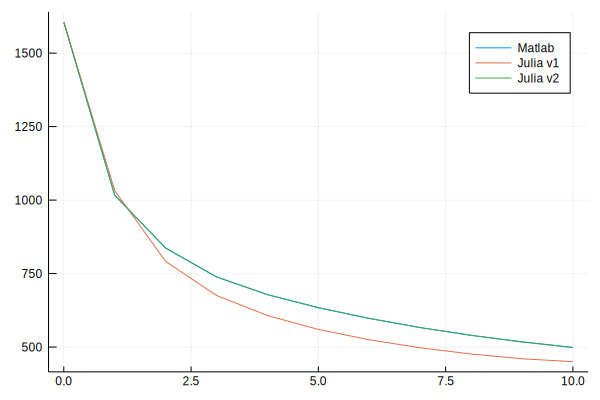

In [99]:
@mget cost_fista
plot(0:10, cost_fista[:], label="Matlab")
plot!(0:10, collect(j_cost_fista), label="Julia v1")
plot!(0:10, collect(j_cost_fista2), label="Julia v2")

The difference here is due to difference locations where cost function evaluated inside an iteration, and also the different ordering of steps. "Julia v1" is the FISTA variant of the general `PGM` method, and thus executes the steps of FISTA in the same order as ISTA and POGM, and evaluates the cost function in the end of the iteration. On the other hand, "Julia v2" follows the description of FISTA algorithm in the referenced paper (and thus also the Matlab implementation), therefore it reproduces successfully the results of the paper.

### Run POGM
#### Matlab code

In [100]:
@time eval_string("[L_pogm,S_pogm,xdiff_pogm,cost_pogm,time_pogm,rankL_pogm] = PGM(param,'pogmS',1,'pogmL',1);")

>>  ite: 0, xdiff: 118.9517593, cost: 1605.9090993, rank of L: 40
 ********** PGM: L+S reconstruction **********
 ite: 1, rank of L: 40, xdiff: 97.3583763, cost: 849.4886573
 ite: 2, rank of L: 40, xdiff: 86.9139863, cost: 707.7278993
 ite: 3, rank of L: 40, xdiff: 78.6276933, cost: 635.4357403
 ite: 4, rank of L: 37, xdiff: 71.0008163, cost: 580.9478443
 ite: 5, rank of L: 32, xdiff: 63.7240603, cost: 539.0874053
 ite: 6, rank of L: 28, xdiff: 56.7864073, cost: 506.9395343
 ite: 7, rank of L: 22, xdiff: 50.2903563, cost: 481.9811793
 ite: 8, rank of L: 19, xdiff: 44.3746223, cost: 462.8262993
 ite: 9, rank of L: 16, xdiff: 39.1518293, cost: 448.2832673
 ite: 10, rank of L: 13, xdiff: 35.6455923, cost: 439.4732693
  3.459792 seconds (23 allocations: 1.250 KiB)


#### Julia equivalent

In [101]:
@time L, S, j_cost_pogm = PGM(kdata, E, T, scale_L = 130/1.2775, scale_S = 1/1.2775,
    λ_L = 0.01, λ_S = 0.01, momentum=:pogm);

k = 0, rank = 40, cost = 1605.909098593456
k = 1, rank = 40, cost = 845.719650195784
k = 2, rank = 40, cost = 701.5183219597353
k = 3, rank = 40, cost = 634.7228529222214
k = 4, rank = 40, cost = 585.6027816423962
k = 5, rank = 36, cost = 547.4927072431932
k = 6, rank = 31, cost = 517.9527494800777
k = 7, rank = 28, cost = 494.6522220980837
k = 8, rank = 24, cost = 476.00986965246165
k = 9, rank = 21, cost = 461.29638034080403
k = 10, rank = 18, cost = 450.22377485651526
 25.582721 seconds (14.85 k allocations: 47.034 GiB, 1.91% gc time)


#### Comparism

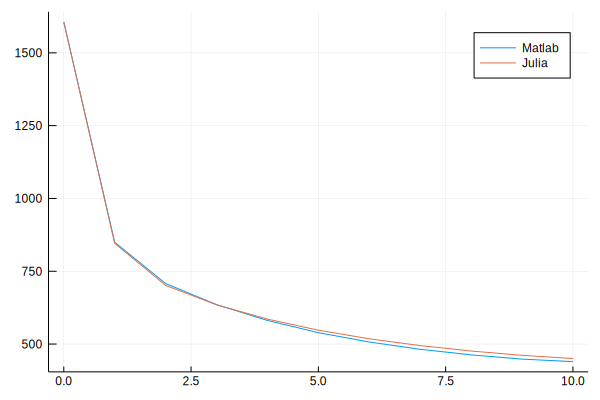

In [102]:
@mget cost_pogm
plot(0:10, cost_pogm[:], label="Matlab")
plot!(0:10, collect(j_cost_pogm), label="Julia")

## Show POGM result

┌ Warning: magnitude at none 0 #jim(): 
└ @ MIRT /home/hakkelt/.julia/packages/MIRT/013iB/src/plot/jim.jl:130


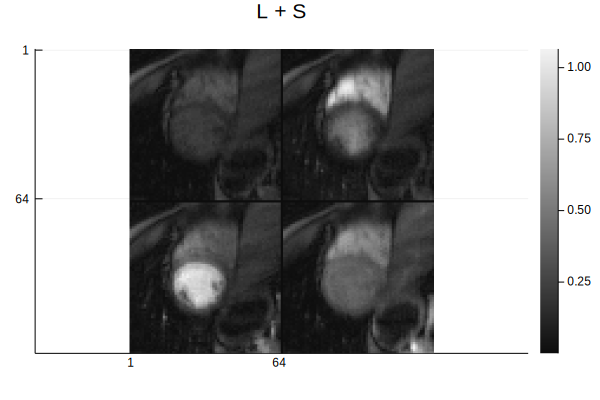

In [103]:
LplusS = L + S
LplusSd = cat(LplusS[33:96,33:96,2], LplusS[33:96,33:96,8], LplusS[33:96,33:96,14], LplusS[33:96,33:96,24], dims=3);
jim(LplusSd, "L + S")

┌ Warning: magnitude at none 0 #jim(): 
└ @ MIRT /home/hakkelt/.julia/packages/MIRT/013iB/src/plot/jim.jl:130


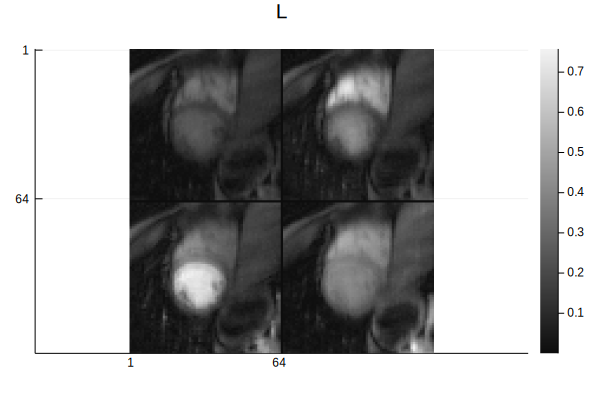

In [104]:
Ld = cat(L[33:96,33:96,2], L[33:96,33:96,8], L[33:96,33:96,14], L[33:96,33:96,24], dims=3);
jim(Ld, "L")

┌ Warning: magnitude at none 0 #jim(): 
└ @ MIRT /home/hakkelt/.julia/packages/MIRT/013iB/src/plot/jim.jl:130


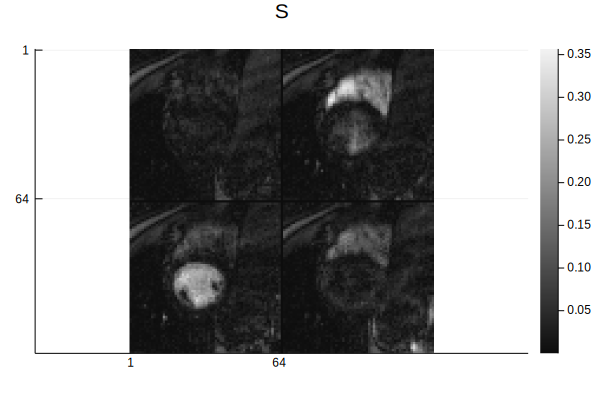

In [105]:
Sd = cat(S[33:96,33:96,2], S[33:96,33:96,8], S[33:96,33:96,14], S[33:96,33:96,24], dims=3);
jim(Sd, "S")